In [161]:
# Import library
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import load_model
import matplotlib.ticker as ticker
from sklearn import metrics
import time
import math
import scipy.stats as stats
import itertools

In [162]:
# Load AKSI stock dataset
df_aksi = pd.read_excel(
    'transportation_stocks.xlsx', sheet_name='AKSI.JK')
df_aksi.set_index('Date', drop=True, inplace=True)
df_aksi.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-04-01,100000000.0,100000000.0,100000000.0,100000000.0,99000000.0,2500.0
2011-04-04,100000000.0,100000000.0,100000000.0,100000000.0,99000000.0,2500.0
2011-04-05,100000000.0,100000000.0,100000000.0,100000000.0,99000000.0,2500.0
2011-04-06,100000000.0,100000000.0,100000000.0,100000000.0,99000000.0,2500.0
2011-04-07,100000000.0,100000000.0,100000000.0,100000000.0,99000000.0,2500.0


In [163]:
# Check datatypes
print(df_aksi.dtypes)

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object


In [164]:
# Check missing value
print(df_aksi.isnull().sum())

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64


In [165]:
# Fill missing value using mean imputation
for i in df_aksi[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]:
    df_aksi[i].fillna(df_aksi[i].mean(), inplace=True)

print(df_aksi.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


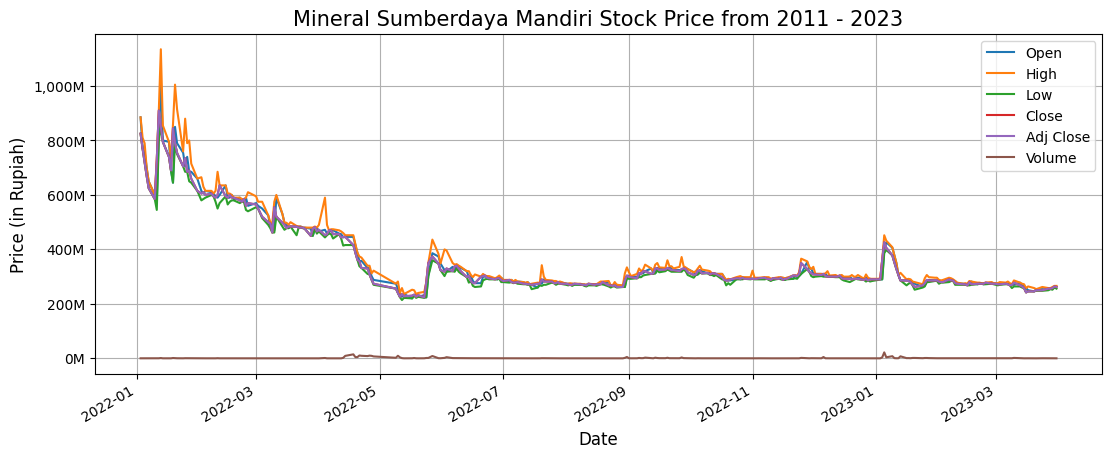

In [166]:
# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# Visualize the historical prices from 2022 - 2023
df_aksi['2022-01-01':].plot(figsize=(13,5))
plt.title('Mineral Sumberdaya Mandiri Stock Price from 2011 - 2023', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

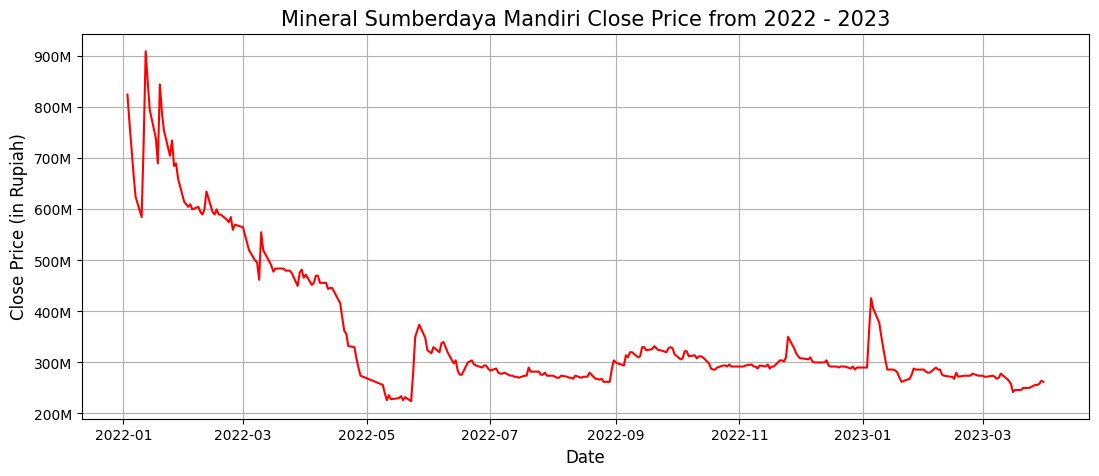

In [167]:
# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# Visualize each of price attributes
plt.figure(figsize=(13,5))
plt.plot(df_aksi['Close']['2022-01-01':], color='red')
plt.title('Mineral Sumberdaya Mandiri Close Price from 2022 - 2023', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

In [168]:
# Select the close price column as the target variable
target_col = 'Close'

# Create a new dataframe with only the target variable
target_df = pd.DataFrame(df_aksi[target_col])

# Split the data into training and testing sets
train_size = int(len(target_df) * 0.9)
train_df = target_df[:train_size]
test_df = target_df[train_size:]
print('Training Set: ', train_df.shape)
print('Testing Set: ', test_df.shape)

Training Set:  (2682, 1)
Testing Set:  (298, 1)


In [169]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)
print('Training Scaled: ', train_scaled[0:5], '\n')
print('Testing Scaled: ', test_scaled[0:5])

Training Scaled:  [[0.02839117]
 [0.02839117]
 [0.02839117]
 [0.02839117]
 [0.02839117]] 

Testing Scaled:  [[0.43217666]
 [0.40063091]
 [0.49842271]
 [0.4637224 ]
 [0.44164038]]


In [170]:
# Define the sequence length and number of features
sequence_length = 60
num_features = 1

# Define the function to create sequences
def create_sequences(X, y, seq_length):
    X_sequences, y_sequences = [], []
    for i in range(seq_length, len(X)):
        X_sequences.append(X[i-seq_length:i, :])
        y_sequences.append(y[i, :])
    return np.array(X_sequences), np.array(y_sequences)

# Create training sequences and labels
X_train, y_train = create_sequences(train_scaled, train_scaled, sequence_length)

# Create testing sequences and labels
X_test, y_test = create_sequences(test_scaled, test_scaled, sequence_length)

# Print the shape of the training and testing sets
print('X train shape:', X_train.shape)
print('y train shape:', y_train.shape)
print('X test shape:', X_test.shape)
print('y test shape:', y_test.shape)

X train shape: (2622, 60, 1)
y train shape: (2622, 1)
X test shape: (238, 60, 1)
y test shape: (238, 1)


##### LSTM Network Default Model

In [171]:
# define the model
model = Sequential()
model.add(LSTM(32, input_shape=(sequence_length, num_features)))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error')
# train the model
model.fit(X_train, y_train, epochs=10, 
          batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 5s 67ms/step - loss: 0.0054 - val_loss: 0.0045
Epoch 2/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0017 - val_loss: 0.0040
Epoch 3/10
24/24 [==============================] - 1s 37ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 4/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 5/10
24/24 [==============================] - 1s 42ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 6/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0010 - val_loss: 0.0022
Epoch 7/10
24/24 [==============================] - 1s 34ms/step - loss: 9.2778e-04 - val_loss: 0.0027
Epoch 8/10
24/24 [==============================] - 1s 31ms/step - loss: 8.7687e-04 - val_loss: 0.0021
Epoch 9/10
24/24 [==============================] - 1s 31ms/step - loss: 7.9678e-04 - val_loss: 0.0020
Epoch 10/10
24/24 [==============================] - 1s 31ms/step - loss: 7.4557e-04 - val_loss: 

In [172]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 1s 8ms/step
Mean Absolute Percentage Error (MAPE):  0.05343
Mean Absolute Error (MAE):  0.0084377
Mean Squared Error (MSE):  0.0002085
Root Mean Squared Error (RMSE):  0.01444
R-Squared:  0.490313


8/8 [==============================] - 0s 8ms/step


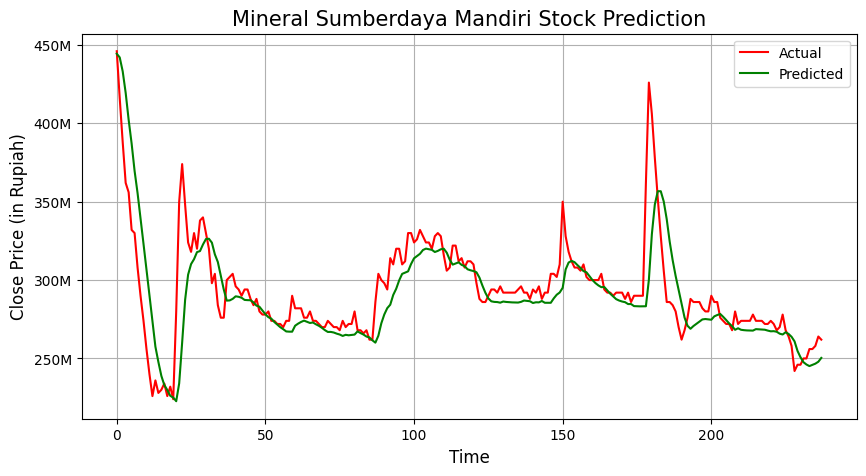

In [173]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/aksi_lstm_default.h5')

##### Linear - Adam

In [174]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 19s 474ms/step - loss: 0.0053 - val_loss: 0.0071
Epoch 2/10
24/24 [==============================] - 11s 444ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 3/10
24/24 [==============================] - 11s 455ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 4/10
24/24 [==============================] - 11s 464ms/step - loss: 0.0012 - val_loss: 0.0032
Epoch 5/10
24/24 [==============================] - 11s 461ms/step - loss: 0.0012 - val_loss: 0.0036
Epoch 6/10
24/24 [==============================] - 11s 462ms/step - loss: 9.8244e-04 - val_loss: 0.0027
Epoch 7/10
24/24 [==============================] - 11s 447ms/step - loss: 9.2000e-04 - val_loss: 0.0027
Epoch 8/10
24/24 [==============================] - 10s 430ms/step - loss: 8.6247e-04 - val_loss: 0.0025
Epoch 9/10
24/24 [==============================] - 11s 439ms/step - loss: 9.1783e-04 - val_loss: 0.0025
Epoch 10/10
24/24 [==============================] - 12s 513ms/step - loss:

In [175]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 56ms/step
Mean Absolute Percentage Error (MAPE):  0.07649
Mean Absolute Error (MAE):  0.0116493
Mean Squared Error (MSE):  0.0002558
Root Mean Squared Error (RMSE):  0.01599
R-Squared:  0.374471


8/8 [==============================] - 0s 51ms/step


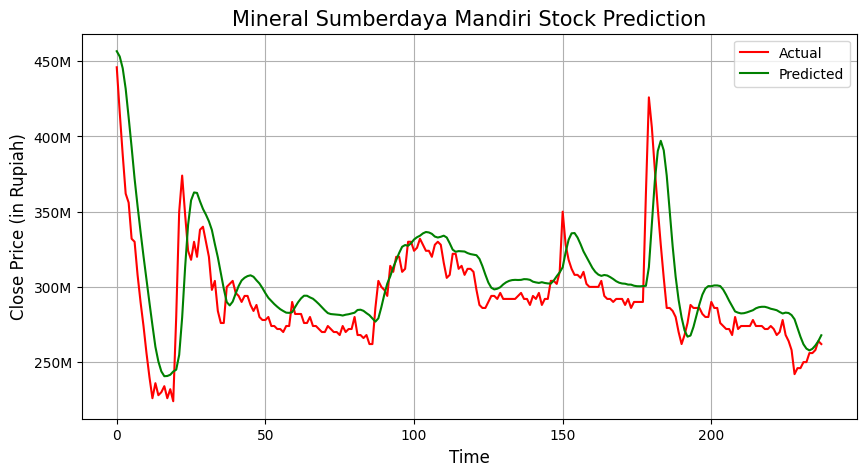

In [176]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

# Save the default model
model.save('models/aksi_linear_adam.h5')

##### Linear - AdaGrad

In [177]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', 
              optimizer='adagrad')
# train the model
model.fit(X_train, y_train, epochs=10, 
          batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 22s 580ms/step - loss: 0.0121 - val_loss: 0.0469
Epoch 2/10
24/24 [==============================] - 13s 540ms/step - loss: 0.0100 - val_loss: 0.0401
Epoch 3/10
24/24 [==============================] - 13s 528ms/step - loss: 0.0096 - val_loss: 0.0374
Epoch 4/10
24/24 [==============================] - 12s 515ms/step - loss: 0.0091 - val_loss: 0.0364
Epoch 5/10
24/24 [==============================] - 12s 480ms/step - loss: 0.0090 - val_loss: 0.0352
Epoch 6/10
24/24 [==============================] - 12s 482ms/step - loss: 0.0085 - val_loss: 0.0336
Epoch 7/10
24/24 [==============================] - 12s 518ms/step - loss: 0.0085 - val_loss: 0.0330
Epoch 8/10
24/24 [==============================] - 13s 553ms/step - loss: 0.0084 - val_loss: 0.0312
Epoch 9/10
24/24 [==============================] - 13s 521ms/step - loss: 0.0081 - val_loss: 0.0309
Epoch 10/10
24/24 [==============================] - 13s 536ms/step - loss: 0.0078 - val_lo

In [178]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 3s 73ms/step
Mean Absolute Percentage Error (MAPE):  0.1984
Mean Absolute Error (MAE):  0.0309219
Mean Squared Error (MSE):  0.0012043
Root Mean Squared Error (RMSE):  0.0347
R-Squared:  -1.944406


8/8 [==============================] - 0s 55ms/step


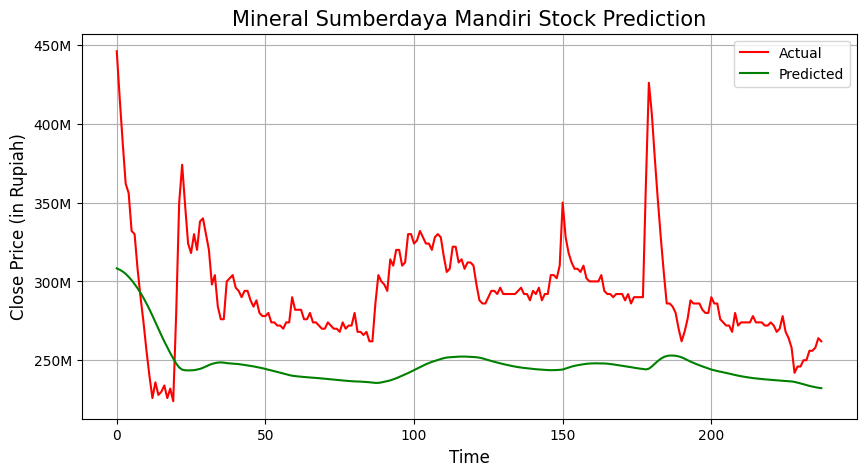

In [179]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

# Save the default model
model.save('models/aksi_linear_adagrad.h5')

##### Linear - Nadam

In [180]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 25s 582ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 2/10
24/24 [==============================] - 11s 457ms/step - loss: 0.0020 - val_loss: 0.0042
Epoch 3/10
24/24 [==============================] - 12s 495ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 4/10
24/24 [==============================] - 11s 441ms/step - loss: 0.0011 - val_loss: 0.0028
Epoch 5/10
24/24 [==============================] - 11s 453ms/step - loss: 9.5019e-04 - val_loss: 0.0027
Epoch 6/10
24/24 [==============================] - 12s 519ms/step - loss: 8.4548e-04 - val_loss: 0.0026
Epoch 7/10
24/24 [==============================] - 13s 539ms/step - loss: 8.7805e-04 - val_loss: 0.0026
Epoch 8/10
24/24 [==============================] - 13s 537ms/step - loss: 8.8266e-04 - val_loss: 0.0024
Epoch 9/10
24/24 [==============================] - 13s 534ms/step - loss: 7.6934e-04 - val_loss: 0.0024
Epoch 10/10
24/24 [==============================] - 13s 552ms/step - l

In [181]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 60ms/step
Mean Absolute Percentage Error (MAPE):  0.05253
Mean Absolute Error (MAE):  0.0082408
Mean Squared Error (MSE):  0.0001923
Root Mean Squared Error (RMSE):  0.01387
R-Squared:  0.529798


8/8 [==============================] - 1s 66ms/step


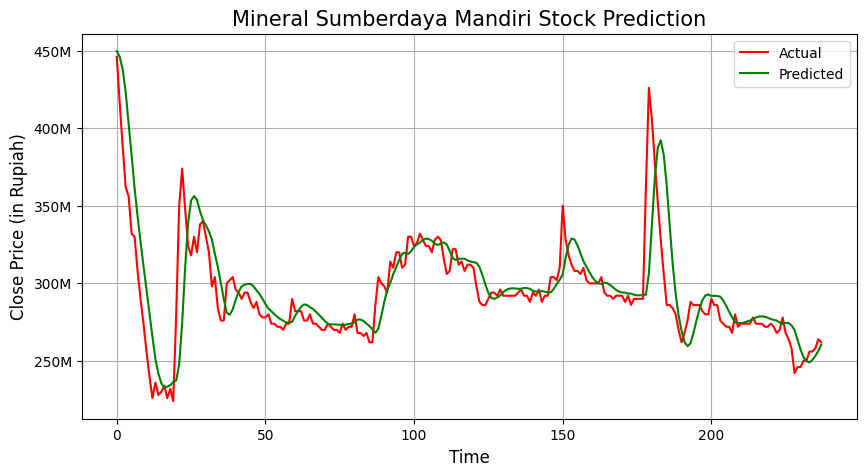

In [182]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

# Save the default model
model.save('models/aksi_linear_nadam.h5')

#### Linear - RMSProp

In [183]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 23s 582ms/step - loss: 0.0044 - val_loss: 0.0124
Epoch 2/10
24/24 [==============================] - 11s 477ms/step - loss: 0.0026 - val_loss: 0.0035
Epoch 3/10
24/24 [==============================] - 11s 481ms/step - loss: 0.0021 - val_loss: 0.0052
Epoch 4/10
24/24 [==============================] - 11s 475ms/step - loss: 0.0019 - val_loss: 0.0044
Epoch 5/10
24/24 [==============================] - 11s 445ms/step - loss: 0.0018 - val_loss: 0.0045
Epoch 6/10
24/24 [==============================] - 10s 424ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 7/10
24/24 [==============================] - 11s 460ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 8/10
24/24 [==============================] - 10s 418ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 9/10
24/24 [==============================] - 9s 390ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 10/10
24/24 [==============================] - 10s 405ms/step - loss: 0.0014 - val_los

In [184]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 73ms/step
Mean Absolute Percentage Error (MAPE):  0.10284
Mean Absolute Error (MAE):  0.0158523
Mean Squared Error (MSE):  0.0004151
Root Mean Squared Error (RMSE):  0.02037
R-Squared:  -0.014989


8/8 [==============================] - 1s 63ms/step


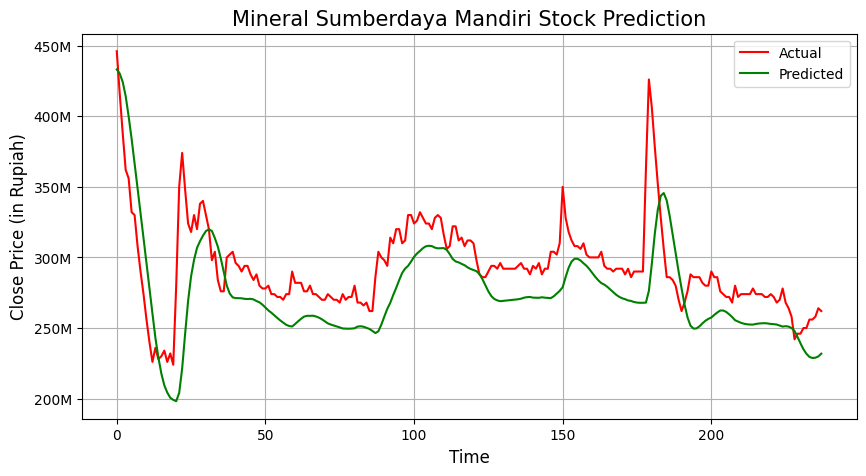

In [185]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/aksi_linear_rmsprop.h5')

##### Linear - AdaDelta

In [186]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 20s 481ms/step - loss: 0.0230 - val_loss: 0.1086
Epoch 2/10
24/24 [==============================] - 11s 460ms/step - loss: 0.0226 - val_loss: 0.1068
Epoch 3/10
24/24 [==============================] - 11s 466ms/step - loss: 0.0222 - val_loss: 0.1051
Epoch 4/10
24/24 [==============================] - 11s 471ms/step - loss: 0.0215 - val_loss: 0.1033
Epoch 5/10
24/24 [==============================] - 11s 473ms/step - loss: 0.0212 - val_loss: 0.1016
Epoch 6/10
24/24 [==============================] - 12s 496ms/step - loss: 0.0209 - val_loss: 0.0998
Epoch 7/10
24/24 [==============================] - 12s 485ms/step - loss: 0.0205 - val_loss: 0.0981
Epoch 8/10
24/24 [==============================] - 11s 449ms/step - loss: 0.0202 - val_loss: 0.0964
Epoch 9/10
24/24 [==============================] - 10s 418ms/step - loss: 0.0197 - val_loss: 0.0948
Epoch 10/10
24/24 [==============================] - 10s 428ms/step - loss: 0.0193 - val_lo

In [187]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 52ms/step
Mean Absolute Percentage Error (MAPE):  0.82534
Mean Absolute Error (MAE):  0.1243952
Mean Squared Error (MSE):  0.0158627
Root Mean Squared Error (RMSE):  0.12595
R-Squared:  -37.784389


8/8 [==============================] - 0s 50ms/step


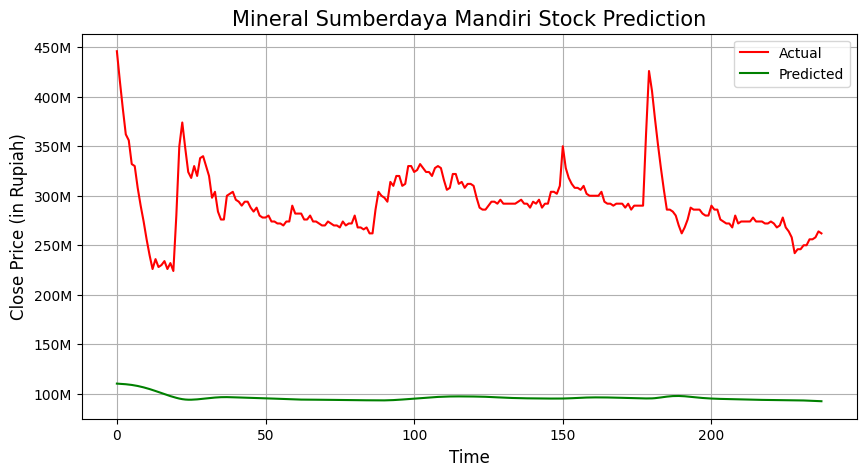

In [188]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/aksi_linear_adadelta.h5')

##### Linear - SGD

In [189]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 18s 484ms/step - loss: 0.0170 - val_loss: 0.0647
Epoch 2/10
24/24 [==============================] - 10s 438ms/step - loss: 0.0146 - val_loss: 0.0577
Epoch 3/10
24/24 [==============================] - 11s 453ms/step - loss: 0.0137 - val_loss: 0.0578
Epoch 4/10
24/24 [==============================] - 12s 483ms/step - loss: 0.0131 - val_loss: 0.0532
Epoch 5/10
24/24 [==============================] - 12s 500ms/step - loss: 0.0123 - val_loss: 0.0504
Epoch 6/10
24/24 [==============================] - 12s 523ms/step - loss: 0.0118 - val_loss: 0.0486
Epoch 7/10
24/24 [==============================] - 13s 522ms/step - loss: 0.0113 - val_loss: 0.0487
Epoch 8/10
24/24 [==============================] - 12s 510ms/step - loss: 0.0108 - val_loss: 0.0429
Epoch 9/10
24/24 [==============================] - 12s 513ms/step - loss: 0.0101 - val_loss: 0.0384
Epoch 10/10
24/24 [==============================] - 13s 527ms/step - loss: 0.0097 - val_lo

In [190]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 50ms/step
Mean Absolute Percentage Error (MAPE):  0.21132
Mean Absolute Error (MAE):  0.0331769
Mean Squared Error (MSE):  0.0013926
Root Mean Squared Error (RMSE):  0.03732
R-Squared:  -2.404983


8/8 [==============================] - 0s 48ms/step


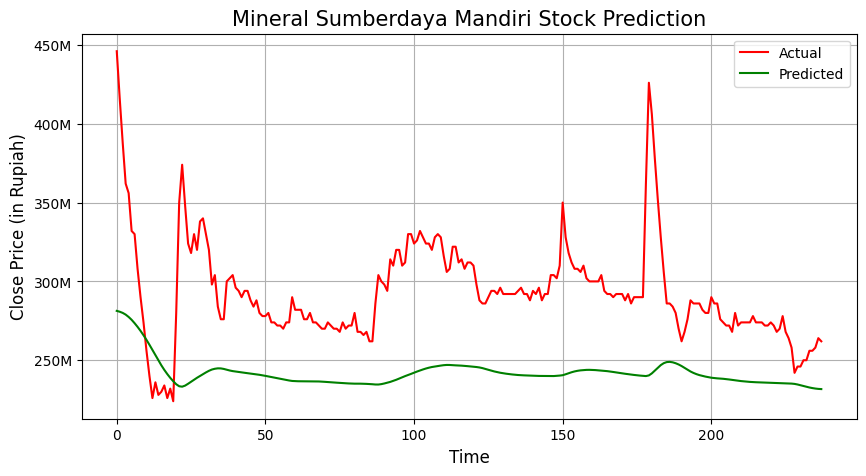

In [191]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/aksi_linear_sgd.h5')

#### Linear - Adamax

In [192]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 20s 514ms/step - loss: 0.0048 - val_loss: 0.0052
Epoch 2/10
24/24 [==============================] - 11s 470ms/step - loss: 0.0025 - val_loss: 0.0037
Epoch 3/10
24/24 [==============================] - 12s 502ms/step - loss: 0.0018 - val_loss: 0.0041
Epoch 4/10
24/24 [==============================] - 12s 499ms/step - loss: 0.0017 - val_loss: 0.0037
Epoch 5/10
24/24 [==============================] - 11s 478ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 6/10
24/24 [==============================] - 10s 421ms/step - loss: 0.0014 - val_loss: 0.0033
Epoch 7/10
24/24 [==============================] - 9s 395ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 8/10
24/24 [==============================] - 10s 407ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 9/10
24/24 [==============================] - 10s 398ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 10/10
24/24 [==============================] - 10s 399ms/step - loss: 0.0012 - val_los

In [193]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 42ms/step
Mean Absolute Percentage Error (MAPE):  0.07529
Mean Absolute Error (MAE):  0.0115842
Mean Squared Error (MSE):  0.0003443
Root Mean Squared Error (RMSE):  0.01856
R-Squared:  0.158095


8/8 [==============================] - 0s 42ms/step


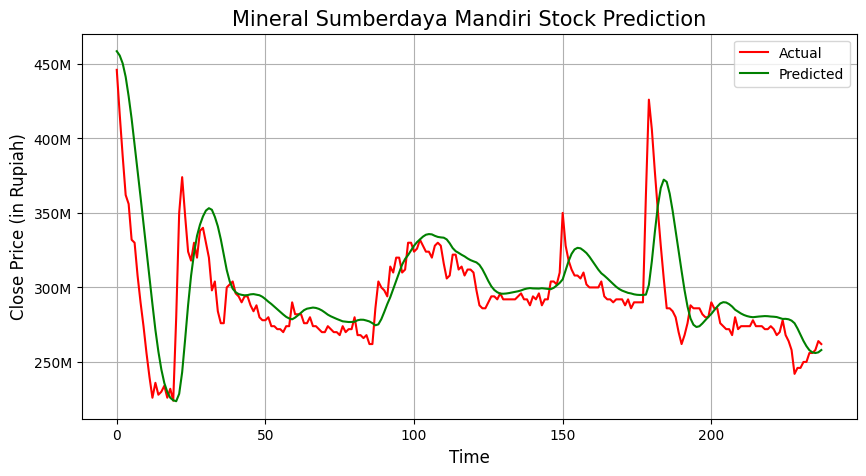

In [194]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/aksi_linear_adamax.h5')

##### ReLU - Adam

In [195]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 18s 454ms/step - loss: 0.0060 - val_loss: 0.0063
Epoch 2/10
24/24 [==============================] - 9s 381ms/step - loss: 0.0021 - val_loss: 0.0033
Epoch 3/10
24/24 [==============================] - 10s 408ms/step - loss: 0.0015 - val_loss: 0.0038
Epoch 4/10
24/24 [==============================] - 9s 395ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 5/10
24/24 [==============================] - 9s 390ms/step - loss: 0.0012 - val_loss: 0.0032
Epoch 6/10
24/24 [==============================] - 9s 387ms/step - loss: 9.9613e-04 - val_loss: 0.0031
Epoch 7/10
24/24 [==============================] - 9s 391ms/step - loss: 9.4539e-04 - val_loss: 0.0027
Epoch 8/10
24/24 [==============================] - 10s 407ms/step - loss: 9.8595e-04 - val_loss: 0.0028
Epoch 9/10
24/24 [==============================] - 9s 392ms/step - loss: 9.9397e-04 - val_loss: 0.0024
Epoch 10/10
24/24 [==============================] - 10s 403ms/step - loss: 9.890

In [196]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 40ms/step
Mean Absolute Percentage Error (MAPE):  0.07423
Mean Absolute Error (MAE):  0.0115348
Mean Squared Error (MSE):  0.0003069
Root Mean Squared Error (RMSE):  0.01752
R-Squared:  0.249605


8/8 [==============================] - 0s 42ms/step


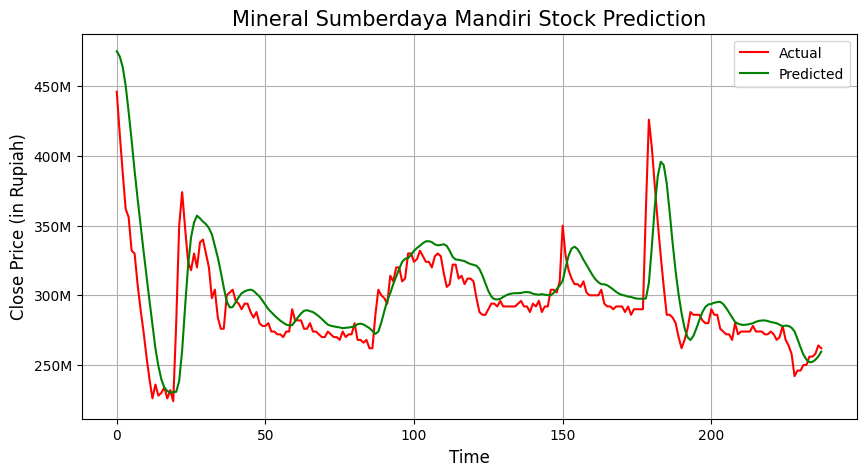

In [197]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/aksi_relu_adam.h5')

#### ReLU - AdaGrad

In [198]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 20s 532ms/step - loss: 0.0190 - val_loss: 0.0808
Epoch 2/10
24/24 [==============================] - 9s 386ms/step - loss: 0.0148 - val_loss: 0.0671
Epoch 3/10
24/24 [==============================] - 10s 403ms/step - loss: 0.0132 - val_loss: 0.0594
Epoch 4/10
24/24 [==============================] - 9s 382ms/step - loss: 0.0125 - val_loss: 0.0546
Epoch 5/10
24/24 [==============================] - 9s 385ms/step - loss: 0.0120 - val_loss: 0.0514
Epoch 6/10
24/24 [==============================] - 9s 379ms/step - loss: 0.0118 - val_loss: 0.0491
Epoch 7/10
24/24 [==============================] - 9s 377ms/step - loss: 0.0115 - val_loss: 0.0475
Epoch 8/10
24/24 [==============================] - 9s 379ms/step - loss: 0.0114 - val_loss: 0.0462
Epoch 9/10
24/24 [==============================] - 9s 389ms/step - loss: 0.0110 - val_loss: 0.0451
Epoch 10/10
24/24 [==============================] - 9s 388ms/step - loss: 0.0108 - val_loss: 0.04

In [199]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 38ms/step
Mean Absolute Percentage Error (MAPE):  0.26565
Mean Absolute Error (MAE):  0.0414706
Mean Squared Error (MSE):  0.00206
Root Mean Squared Error (RMSE):  0.04539
R-Squared:  -4.03665


8/8 [==============================] - 0s 39ms/step


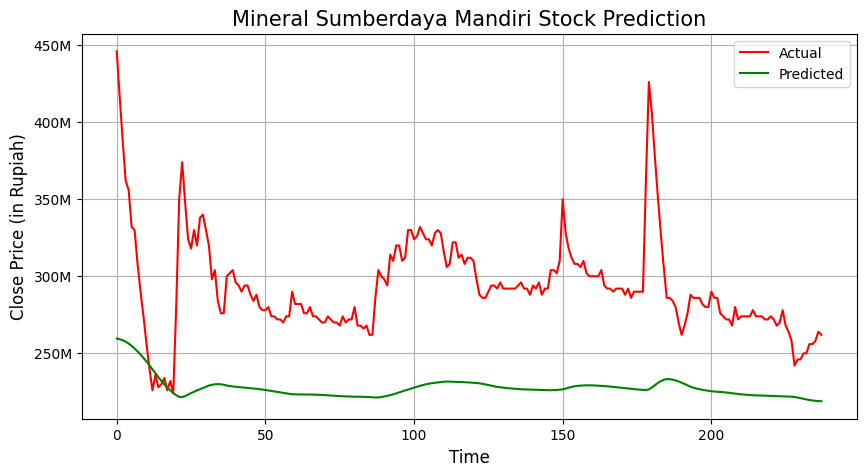

In [200]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/aksi_relu_adagrad.h5')

##### ReLU - Nadam

In [201]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 17s 405ms/step - loss: 0.0043 - val_loss: 0.0053
Epoch 2/10
24/24 [==============================] - 8s 350ms/step - loss: 0.0019 - val_loss: 0.0034
Epoch 3/10
24/24 [==============================] - 9s 357ms/step - loss: 0.0013 - val_loss: 0.0033
Epoch 4/10
24/24 [==============================] - 9s 362ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 5/10
24/24 [==============================] - 9s 365ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 6/10
24/24 [==============================] - 9s 379ms/step - loss: 0.0010 - val_loss: 0.0032
Epoch 7/10
24/24 [==============================] - 9s 367ms/step - loss: 8.5220e-04 - val_loss: 0.0027
Epoch 8/10
24/24 [==============================] - 9s 375ms/step - loss: 9.0276e-04 - val_loss: 0.0025
Epoch 9/10
24/24 [==============================] - 9s 367ms/step - loss: 8.1583e-04 - val_loss: 0.0024
Epoch 10/10
24/24 [==============================] - 9s 372ms/step - loss: 8.6848e-04 -

In [202]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 37ms/step
Mean Absolute Percentage Error (MAPE):  0.11413
Mean Absolute Error (MAE):  0.0171377
Mean Squared Error (MSE):  0.0004211
Root Mean Squared Error (RMSE):  0.02052
R-Squared:  -0.029488


8/8 [==============================] - 0s 38ms/step


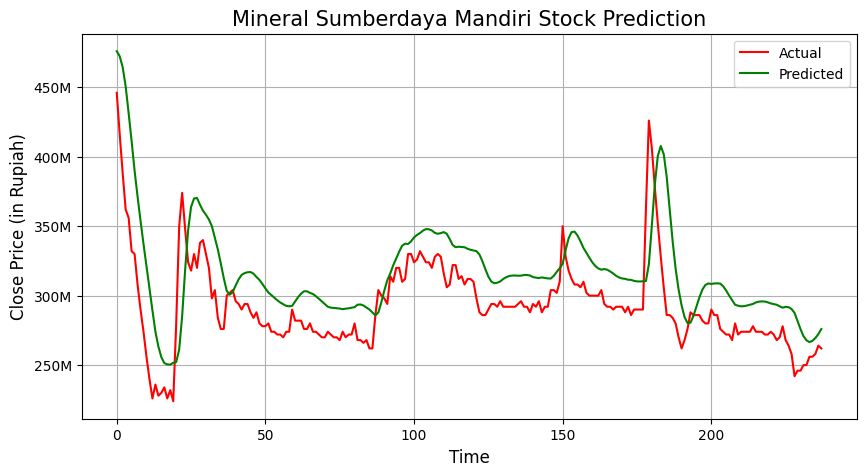

In [203]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/aksi_relu_nadam.h5')

##### ReLU - RMSProp

In [204]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 16s 412ms/step - loss: 0.0066 - val_loss: 0.0044
Epoch 2/10
24/24 [==============================] - 9s 379ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 3/10
24/24 [==============================] - 9s 376ms/step - loss: 0.0023 - val_loss: 0.0036
Epoch 4/10
24/24 [==============================] - 9s 393ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 5/10
24/24 [==============================] - 9s 380ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 6/10
24/24 [==============================] - 9s 385ms/step - loss: 0.0016 - val_loss: 0.0052
Epoch 7/10
24/24 [==============================] - 9s 383ms/step - loss: 0.0016 - val_loss: 0.0040
Epoch 8/10
24/24 [==============================] - 9s 384ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 9/10
24/24 [==============================] - 10s 399ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 10/10
24/24 [==============================] - 9s 386ms/step - loss: 0.0013 - val_loss: 0.00

In [205]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 37ms/step
Mean Absolute Percentage Error (MAPE):  0.08627
Mean Absolute Error (MAE):  0.013357
Mean Squared Error (MSE):  0.0003701
Root Mean Squared Error (RMSE):  0.01924
R-Squared:  0.095033


8/8 [==============================] - 0s 43ms/step


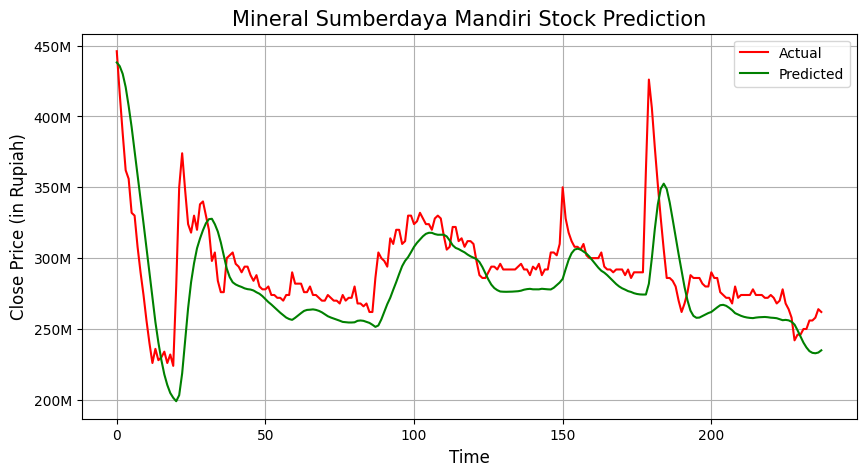

In [206]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/aksi_relu_rmsprop.h5')

##### ReLU - AdaDelta

In [207]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 16s 407ms/step - loss: 0.0238 - val_loss: 0.1125
Epoch 2/10
24/24 [==============================] - 9s 375ms/step - loss: 0.0235 - val_loss: 0.1114
Epoch 3/10
24/24 [==============================] - 9s 392ms/step - loss: 0.0233 - val_loss: 0.1104
Epoch 4/10
24/24 [==============================] - 9s 388ms/step - loss: 0.0230 - val_loss: 0.1093
Epoch 5/10
24/24 [==============================] - 10s 406ms/step - loss: 0.0227 - val_loss: 0.1083
Epoch 6/10
24/24 [==============================] - 9s 395ms/step - loss: 0.0225 - val_loss: 0.1073
Epoch 7/10
24/24 [==============================] - 10s 404ms/step - loss: 0.0222 - val_loss: 0.1063
Epoch 8/10
24/24 [==============================] - 10s 399ms/step - loss: 0.0220 - val_loss: 0.1054
Epoch 9/10
24/24 [==============================] - 9s 392ms/step - loss: 0.0219 - val_loss: 0.1044
Epoch 10/10
24/24 [==============================] - 10s 399ms/step - loss: 0.0215 - val_loss: 0

In [208]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 1s 36ms/step
Mean Absolute Percentage Error (MAPE):  0.89646
Mean Absolute Error (MAE):  0.1349379
Mean Squared Error (MSE):  0.0186074
Root Mean Squared Error (RMSE):  0.13641
R-Squared:  -44.495184


8/8 [==============================] - 0s 38ms/step


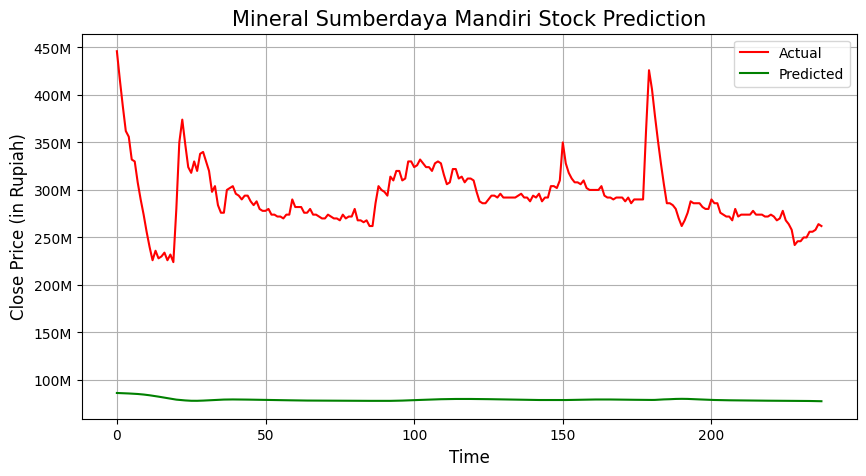

In [209]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/aksi_relu_adadelta.h5')

##### ReLU - SGD

In [210]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 17s 450ms/step - loss: 0.0197 - val_loss: 0.0749
Epoch 2/10
24/24 [==============================] - 10s 414ms/step - loss: 0.0150 - val_loss: 0.0619
Epoch 3/10
24/24 [==============================] - 10s 415ms/step - loss: 0.0142 - val_loss: 0.0573
Epoch 4/10
24/24 [==============================] - 10s 407ms/step - loss: 0.0137 - val_loss: 0.0552
Epoch 5/10
24/24 [==============================] - 10s 424ms/step - loss: 0.0132 - val_loss: 0.0538
Epoch 6/10
24/24 [==============================] - 10s 410ms/step - loss: 0.0127 - val_loss: 0.0521
Epoch 7/10
24/24 [==============================] - 10s 434ms/step - loss: 0.0124 - val_loss: 0.0507
Epoch 8/10
24/24 [==============================] - 10s 416ms/step - loss: 0.0120 - val_loss: 0.0487
Epoch 9/10
24/24 [==============================] - 10s 422ms/step - loss: 0.0116 - val_loss: 0.0468
Epoch 10/10
24/24 [==============================] - 10s 412ms/step - loss: 0.0110 - val_lo

In [211]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 47ms/step
Mean Absolute Percentage Error (MAPE):  0.26433
Mean Absolute Error (MAE):  0.0412585
Mean Squared Error (MSE):  0.0020396
Root Mean Squared Error (RMSE):  0.04516
R-Squared:  -3.986736


8/8 [==============================] - 0s 40ms/step


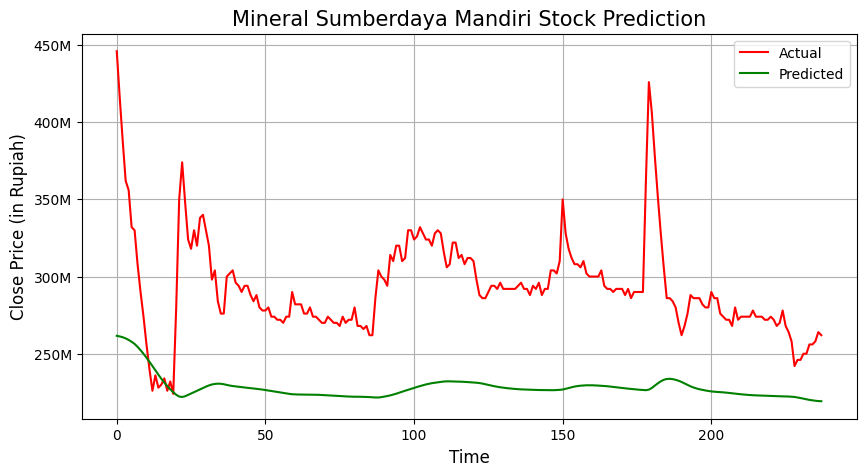

In [212]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/aksi_relu_sgd.h5')

##### ReLU - Adamax

In [213]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 15s 414ms/step - loss: 0.0079 - val_loss: 0.0059
Epoch 2/10
24/24 [==============================] - 9s 386ms/step - loss: 0.0027 - val_loss: 0.0050
Epoch 3/10
24/24 [==============================] - 9s 395ms/step - loss: 0.0023 - val_loss: 0.0040
Epoch 4/10
24/24 [==============================] - 10s 402ms/step - loss: 0.0021 - val_loss: 0.0038
Epoch 5/10
24/24 [==============================] - 9s 390ms/step - loss: 0.0019 - val_loss: 0.0036
Epoch 6/10
24/24 [==============================] - 10s 399ms/step - loss: 0.0017 - val_loss: 0.0037
Epoch 7/10
24/24 [==============================] - 10s 397ms/step - loss: 0.0017 - val_loss: 0.0038
Epoch 8/10
24/24 [==============================] - 9s 396ms/step - loss: 0.0016 - val_loss: 0.0038
Epoch 9/10
24/24 [==============================] - 10s 404ms/step - loss: 0.0013 - val_loss: 0.0037
Epoch 10/10
24/24 [==============================] - 10s 398ms/step - loss: 0.0015 - val_loss: 

In [214]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 40ms/step
Mean Absolute Percentage Error (MAPE):  0.11345
Mean Absolute Error (MAE):  0.0168892
Mean Squared Error (MSE):  0.0004888
Root Mean Squared Error (RMSE):  0.02211
R-Squared:  -0.194999


8/8 [==============================] - 0s 43ms/step


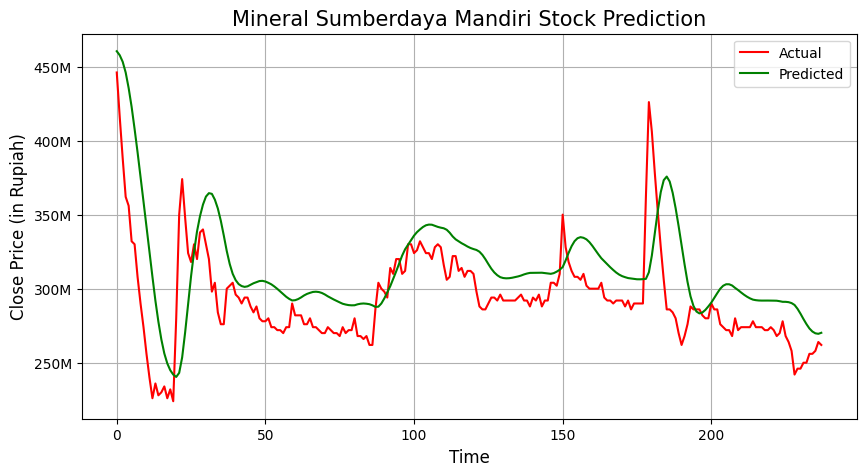

In [215]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/aksi_relu_adamax.h5')

##### Sigmoid - Adam

In [216]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 17s 430ms/step - loss: 0.8958 - val_loss: 0.1105
Epoch 2/10
24/24 [==============================] - 9s 363ms/step - loss: 0.0301 - val_loss: 0.0643
Epoch 3/10
24/24 [==============================] - 9s 369ms/step - loss: 0.0221 - val_loss: 0.0509
Epoch 4/10
24/24 [==============================] - 9s 376ms/step - loss: 0.0217 - val_loss: 0.0653
Epoch 5/10
24/24 [==============================] - 9s 389ms/step - loss: 0.0195 - val_loss: 0.0485
Epoch 6/10
24/24 [==============================] - 9s 380ms/step - loss: 0.0193 - val_loss: 0.0619
Epoch 7/10
24/24 [==============================] - 10s 398ms/step - loss: 0.0181 - val_loss: 0.0545
Epoch 8/10
24/24 [==============================] - 9s 386ms/step - loss: 0.0180 - val_loss: 0.0562
Epoch 9/10
24/24 [==============================] - 9s 381ms/step - loss: 0.0175 - val_loss: 0.0604
Epoch 10/10
24/24 [==============================] - 9s 386ms/step - loss: 0.0170 - val_loss: 0.05

In [217]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 39ms/step
Mean Absolute Percentage Error (MAPE):  0.15999
Mean Absolute Error (MAE):  0.0256548
Mean Squared Error (MSE):  0.0009973
Root Mean Squared Error (RMSE):  0.03158
R-Squared:  -1.438394


8/8 [==============================] - 0s 45ms/step


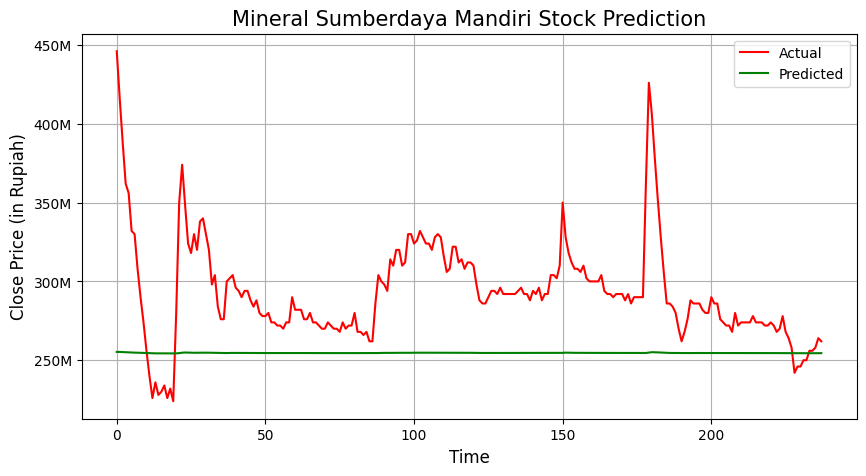

In [218]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/aksi_sigmoid_adam.h5')

##### Sigmoid - AdaGrad

In [219]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 19s 488ms/step - loss: 0.3897 - val_loss: 0.1164
Epoch 2/10
24/24 [==============================] - 10s 437ms/step - loss: 0.2720 - val_loss: 0.0726
Epoch 3/10
24/24 [==============================] - 10s 429ms/step - loss: 0.2096 - val_loss: 0.0477
Epoch 4/10
24/24 [==============================] - 10s 429ms/step - loss: 0.1673 - val_loss: 0.0322
Epoch 5/10
24/24 [==============================] - 10s 428ms/step - loss: 0.1364 - val_loss: 0.0224
Epoch 6/10
24/24 [==============================] - 11s 445ms/step - loss: 0.1127 - val_loss: 0.0163
Epoch 7/10
24/24 [==============================] - 11s 445ms/step - loss: 0.0940 - val_loss: 0.0128
Epoch 8/10
24/24 [==============================] - 11s 455ms/step - loss: 0.0795 - val_loss: 0.0111
Epoch 9/10
24/24 [==============================] - 11s 449ms/step - loss: 0.0674 - val_loss: 0.0107
Epoch 10/10
24/24 [==============================] - 11s 452ms/step - loss: 0.0578 - val_lo

In [220]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 41ms/step
Mean Absolute Percentage Error (MAPE):  1.02725
Mean Absolute Error (MAE):  0.1494138
Mean Squared Error (MSE):  0.0227244
Root Mean Squared Error (RMSE):  0.15075
R-Squared:  -54.56122


8/8 [==============================] - 0s 41ms/step


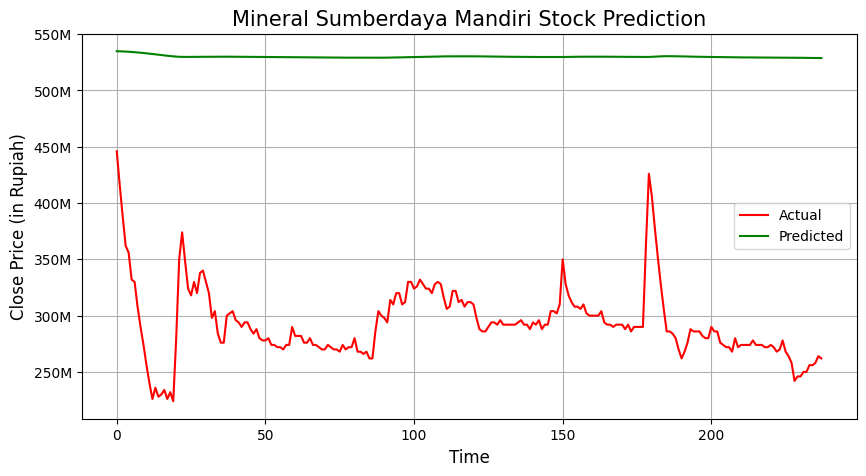

In [221]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/aksi_sigmoid_adagrad.h5')

##### Sigmoid - Nadam

In [222]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 18s 471ms/step - loss: 0.0146 - val_loss: 0.0049
Epoch 2/10
24/24 [==============================] - 10s 410ms/step - loss: 0.0024 - val_loss: 0.0039
Epoch 3/10
24/24 [==============================] - 10s 438ms/step - loss: 0.0016 - val_loss: 0.0038
Epoch 4/10
24/24 [==============================] - 10s 422ms/step - loss: 0.0012 - val_loss: 0.0040
Epoch 5/10
24/24 [==============================] - 10s 438ms/step - loss: 0.0011 - val_loss: 0.0036
Epoch 6/10
24/24 [==============================] - 11s 451ms/step - loss: 0.0011 - val_loss: 0.0034
Epoch 7/10
24/24 [==============================] - 11s 442ms/step - loss: 0.0010 - val_loss: 0.0031
Epoch 8/10
24/24 [==============================] - 10s 427ms/step - loss: 9.6680e-04 - val_loss: 0.0030
Epoch 9/10
24/24 [==============================] - 10s 438ms/step - loss: 9.2566e-04 - val_loss: 0.0029
Epoch 10/10
24/24 [==============================] - 12s 498ms/step - loss: 8.7668e

In [223]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 41ms/step
Mean Absolute Percentage Error (MAPE):  0.09608
Mean Absolute Error (MAE):  0.0145886
Mean Squared Error (MSE):  0.0003917
Root Mean Squared Error (RMSE):  0.01979
R-Squared:  0.042263


8/8 [==============================] - 0s 47ms/step


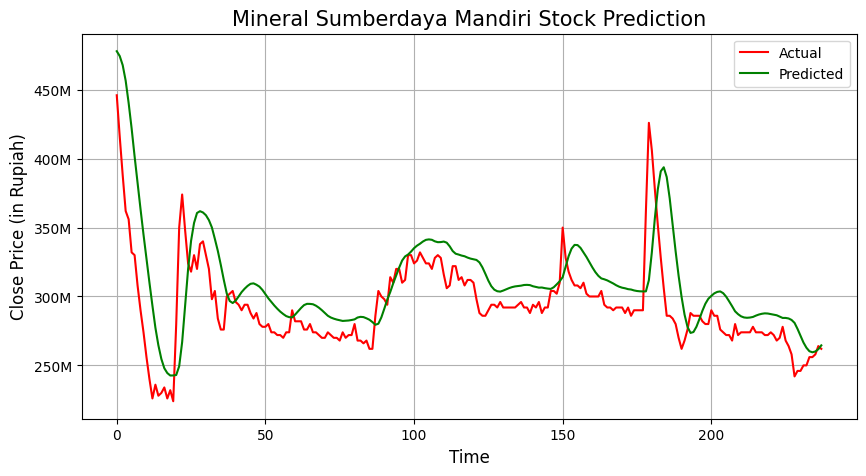

In [224]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/aksi_sigmoid_nadam.h5')

##### Sigmoid - RMSProp

In [225]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 19s 531ms/step - loss: 0.0350 - val_loss: 0.0305
Epoch 2/10
24/24 [==============================] - 13s 540ms/step - loss: 0.0063 - val_loss: 0.0179
Epoch 3/10
24/24 [==============================] - 18s 744ms/step - loss: 0.0045 - val_loss: 0.0156
Epoch 4/10
24/24 [==============================] - 19s 776ms/step - loss: 0.0040 - val_loss: 0.0161
Epoch 5/10
24/24 [==============================] - 14s 583ms/step - loss: 0.0034 - val_loss: 0.0087
Epoch 6/10
24/24 [==============================] - 17s 704ms/step - loss: 0.0034 - val_loss: 0.0097
Epoch 7/10
24/24 [==============================] - 18s 759ms/step - loss: 0.0027 - val_loss: 0.0038
Epoch 8/10
24/24 [==============================] - 15s 631ms/step - loss: 0.0023 - val_loss: 0.0038
Epoch 9/10
24/24 [==============================] - 15s 613ms/step - loss: 0.0021 - val_loss: 0.0034
Epoch 10/10
24/24 [==============================] - 15s 634ms/step - loss: 0.0021 - val_lo

In [226]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 5s 86ms/step
Mean Absolute Percentage Error (MAPE):  0.09498
Mean Absolute Error (MAE):  0.0142545
Mean Squared Error (MSE):  0.0004476
Root Mean Squared Error (RMSE):  0.02116
R-Squared:  -0.094311


8/8 [==============================] - 1s 110ms/step


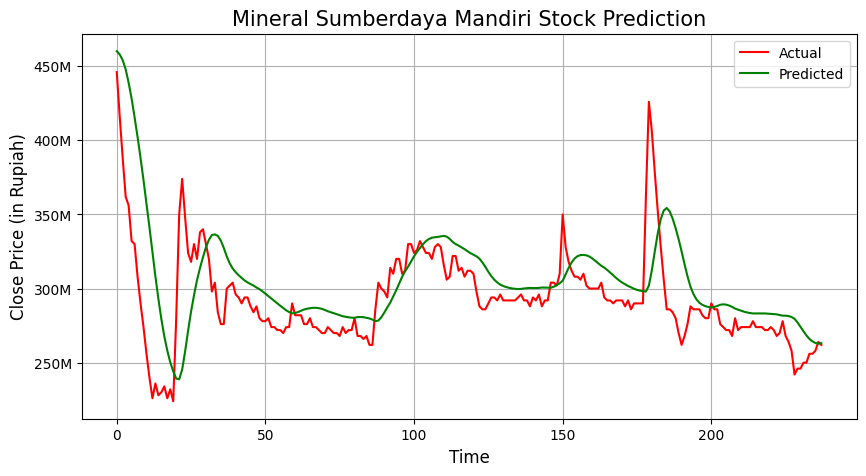

In [227]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/aksi_sigmoid_rmsprop.h5')

##### Sigmoid - AdaDelta

In [228]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 38s 699ms/step - loss: 0.3689 - val_loss: 0.6730
Epoch 2/10
24/24 [==============================] - 13s 554ms/step - loss: 0.3677 - val_loss: 0.6710
Epoch 3/10
24/24 [==============================] - 12s 521ms/step - loss: 0.3663 - val_loss: 0.6689
Epoch 4/10
24/24 [==============================] - 12s 520ms/step - loss: 0.3651 - val_loss: 0.6668
Epoch 5/10
24/24 [==============================] - 12s 518ms/step - loss: 0.3638 - val_loss: 0.6646
Epoch 6/10
24/24 [==============================] - 12s 514ms/step - loss: 0.3624 - val_loss: 0.6625
Epoch 7/10
24/24 [==============================] - 13s 536ms/step - loss: 0.3612 - val_loss: 0.6602
Epoch 8/10
24/24 [==============================] - 13s 541ms/step - loss: 0.3595 - val_loss: 0.6580
Epoch 9/10
24/24 [==============================] - 13s 526ms/step - loss: 0.3583 - val_loss: 0.6557
Epoch 10/10
24/24 [==============================] - 13s 533ms/step - loss: 0.3567 - val_lo

In [229]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 56ms/step
Mean Absolute Percentage Error (MAPE):  4.26657
Mean Absolute Error (MAE):  0.6330449
Mean Squared Error (MSE):  0.4011334
Root Mean Squared Error (RMSE):  0.63335
R-Squared:  -979.773145


8/8 [==============================] - 0s 59ms/step


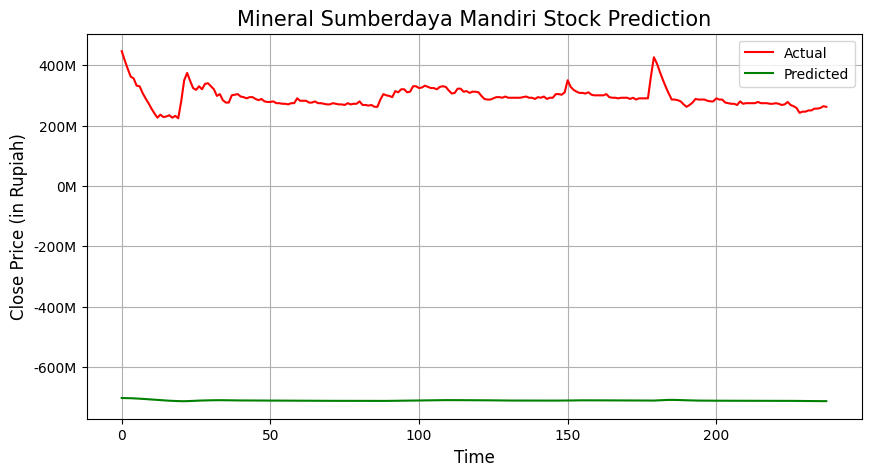

In [230]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/aksi_sigmoid_adadelta.h5')

##### Sigmoid - SGD

In [231]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 23s 582ms/step - loss: 0.0315 - val_loss: 0.0632
Epoch 2/10
24/24 [==============================] - 12s 500ms/step - loss: 0.0150 - val_loss: 0.0645
Epoch 3/10
24/24 [==============================] - 13s 545ms/step - loss: 0.0149 - val_loss: 0.0642
Epoch 4/10
24/24 [==============================] - 16s 663ms/step - loss: 0.0148 - val_loss: 0.0659
Epoch 5/10
24/24 [==============================] - 16s 667ms/step - loss: 0.0147 - val_loss: 0.0650
Epoch 6/10
24/24 [==============================] - 15s 624ms/step - loss: 0.0145 - val_loss: 0.0639
Epoch 7/10
24/24 [==============================] - 13s 537ms/step - loss: 0.0146 - val_loss: 0.0637
Epoch 8/10
24/24 [==============================] - 13s 527ms/step - loss: 0.0144 - val_loss: 0.0588
Epoch 9/10
24/24 [==============================] - 13s 549ms/step - loss: 0.0143 - val_loss: 0.0622
Epoch 10/10
24/24 [==============================] - 14s 576ms/step - loss: 0.0142 - val_lo

In [232]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 3s 73ms/step
Mean Absolute Percentage Error (MAPE):  0.32453
Mean Absolute Error (MAE):  0.0504015
Mean Squared Error (MSE):  0.0029422
Root Mean Squared Error (RMSE):  0.05424
R-Squared:  -6.193797


8/8 [==============================] - 1s 70ms/step


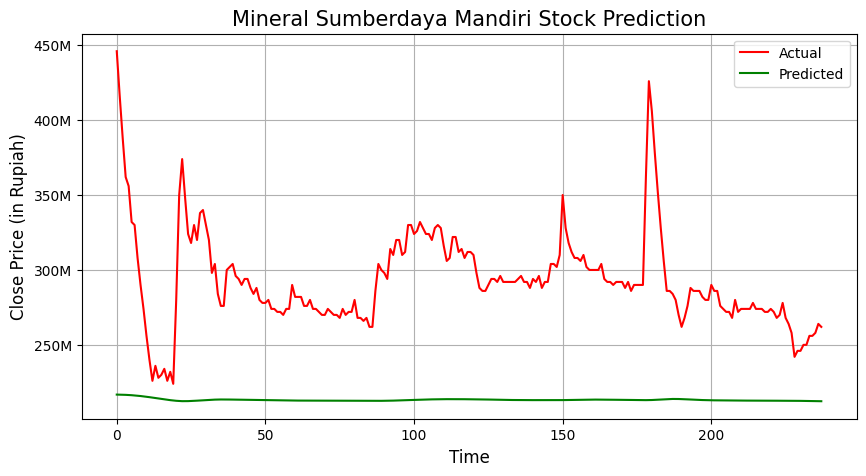

In [233]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/aksi_sigmoid_sgd.h5')

##### Sigmoid - Adamax

In [234]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 30s 723ms/step - loss: 0.0058 - val_loss: 0.0071
Epoch 2/10
24/24 [==============================] - 15s 627ms/step - loss: 0.0028 - val_loss: 0.0044
Epoch 3/10
24/24 [==============================] - 17s 706ms/step - loss: 0.0023 - val_loss: 0.0045
Epoch 4/10
24/24 [==============================] - 14s 569ms/step - loss: 0.0019 - val_loss: 0.0042
Epoch 5/10
24/24 [==============================] - 13s 522ms/step - loss: 0.0018 - val_loss: 0.0056
Epoch 6/10
24/24 [==============================] - 12s 517ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 7/10
24/24 [==============================] - 12s 491ms/step - loss: 0.0013 - val_loss: 0.0039
Epoch 8/10
24/24 [==============================] - 12s 516ms/step - loss: 0.0014 - val_loss: 0.0046
Epoch 9/10
24/24 [==============================] - 13s 561ms/step - loss: 0.0013 - val_loss: 0.0039
Epoch 10/10
24/24 [==============================] - 12s 501ms/step - loss: 0.0012 - val_lo

In [235]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 50ms/step
Mean Absolute Percentage Error (MAPE):  0.07636
Mean Absolute Error (MAE):  0.0118037
Mean Squared Error (MSE):  0.0003877
Root Mean Squared Error (RMSE):  0.01969
R-Squared:  0.051957


8/8 [==============================] - 0s 53ms/step


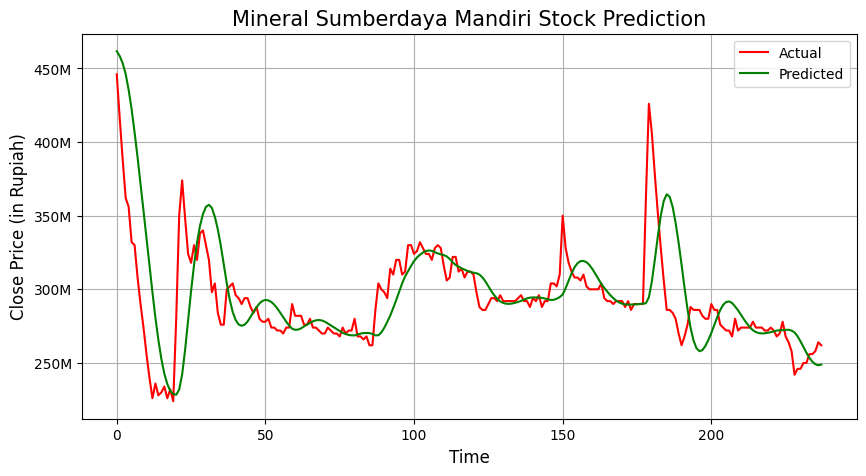

In [236]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/aksi_sigmoid_adamax.h5')

##### Tanh - Adam

In [237]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 22s 590ms/step - loss: 0.0050 - val_loss: 0.0041
Epoch 2/10
24/24 [==============================] - 12s 488ms/step - loss: 0.0014 - val_loss: 0.0042
Epoch 3/10
24/24 [==============================] - 12s 489ms/step - loss: 0.0012 - val_loss: 0.0032
Epoch 4/10
24/24 [==============================] - 12s 496ms/step - loss: 9.8634e-04 - val_loss: 0.0031
Epoch 5/10
24/24 [==============================] - 12s 494ms/step - loss: 9.6724e-04 - val_loss: 0.0028
Epoch 6/10
24/24 [==============================] - 12s 498ms/step - loss: 0.0010 - val_loss: 0.0033
Epoch 7/10
24/24 [==============================] - 12s 515ms/step - loss: 8.6957e-04 - val_loss: 0.0026
Epoch 8/10
24/24 [==============================] - 14s 572ms/step - loss: 8.5292e-04 - val_loss: 0.0037
Epoch 9/10
24/24 [==============================] - 14s 591ms/step - loss: 9.3763e-04 - val_loss: 0.0022
Epoch 10/10
24/24 [==============================] - 12s 513ms/step - l

In [238]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 53ms/step
Mean Absolute Percentage Error (MAPE):  0.05345
Mean Absolute Error (MAE):  0.0084007
Mean Squared Error (MSE):  0.0001969
Root Mean Squared Error (RMSE):  0.01403
R-Squared:  0.518664


8/8 [==============================] - 0s 57ms/step


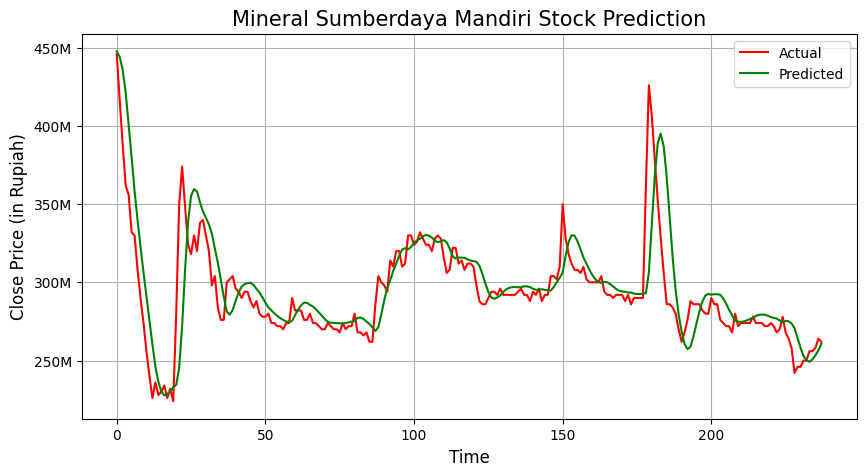

In [239]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/aksi_tanh_adam.h5')

##### Tanh - AdaGrad

In [240]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 20s 553ms/step - loss: 0.0174 - val_loss: 0.0701
Epoch 2/10
24/24 [==============================] - 12s 505ms/step - loss: 0.0140 - val_loss: 0.0598
Epoch 3/10
24/24 [==============================] - 12s 491ms/step - loss: 0.0133 - val_loss: 0.0559
Epoch 4/10
24/24 [==============================] - 12s 481ms/step - loss: 0.0130 - val_loss: 0.0529
Epoch 5/10
24/24 [==============================] - 11s 476ms/step - loss: 0.0125 - val_loss: 0.0520
Epoch 6/10
24/24 [==============================] - 12s 491ms/step - loss: 0.0122 - val_loss: 0.0507
Epoch 7/10
24/24 [==============================] - 12s 483ms/step - loss: 0.0121 - val_loss: 0.0490
Epoch 8/10
24/24 [==============================] - 12s 484ms/step - loss: 0.0119 - val_loss: 0.0475
Epoch 9/10
24/24 [==============================] - 12s 494ms/step - loss: 0.0111 - val_loss: 0.0461
Epoch 10/10
24/24 [==============================] - 12s 502ms/step - loss: 0.0110 - val_lo

In [241]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 53ms/step
Mean Absolute Percentage Error (MAPE):  0.26384
Mean Absolute Error (MAE):  0.0412239
Mean Squared Error (MSE):  0.0020418
Root Mean Squared Error (RMSE):  0.04519
R-Squared:  -3.992157


8/8 [==============================] - 0s 57ms/step


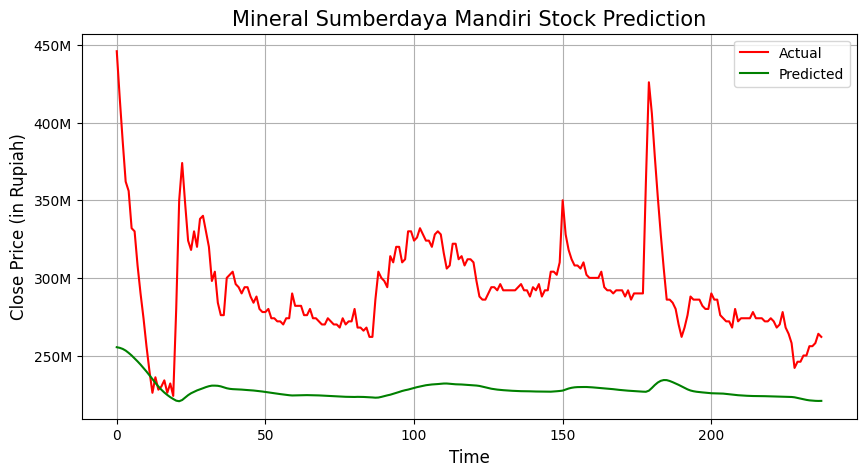

In [242]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/aksi_tanh_adagrad.h5')

##### Tanh - Nadam

In [243]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 25s 582ms/step - loss: 0.0050 - val_loss: 0.0047
Epoch 2/10
24/24 [==============================] - 12s 485ms/step - loss: 0.0018 - val_loss: 0.0037
Epoch 3/10
24/24 [==============================] - 12s 500ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 4/10
24/24 [==============================] - 14s 565ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 5/10
24/24 [==============================] - 13s 562ms/step - loss: 0.0012 - val_loss: 0.0032
Epoch 6/10
24/24 [==============================] - 14s 563ms/step - loss: 8.2793e-04 - val_loss: 0.0028
Epoch 7/10
24/24 [==============================] - 13s 537ms/step - loss: 8.8026e-04 - val_loss: 0.0030
Epoch 8/10
24/24 [==============================] - 13s 536ms/step - loss: 8.8485e-04 - val_loss: 0.0025
Epoch 9/10
24/24 [==============================] - 13s 529ms/step - loss: 7.6679e-04 - val_loss: 0.0031
Epoch 10/10
24/24 [==============================] - 13s 553ms/step - loss:

In [244]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 3s 56ms/step
Mean Absolute Percentage Error (MAPE):  0.06896
Mean Absolute Error (MAE):  0.0107323
Mean Squared Error (MSE):  0.0002682
Root Mean Squared Error (RMSE):  0.01638
R-Squared:  0.344137


8/8 [==============================] - 1s 99ms/step


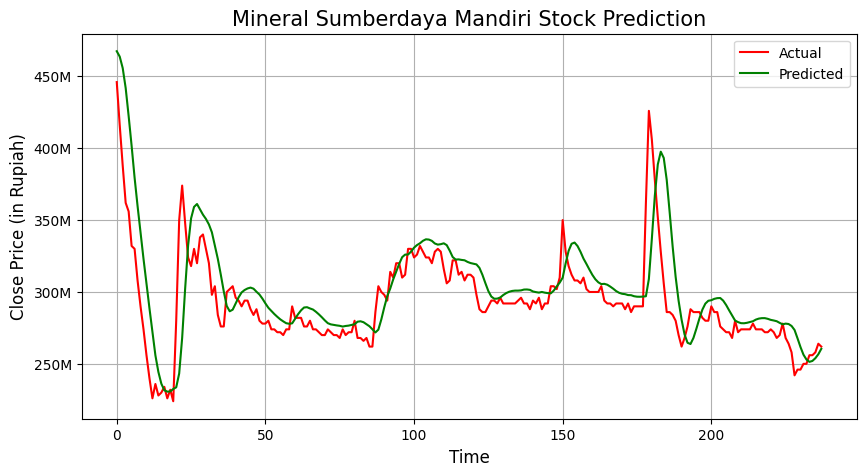

In [245]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/aksi_tanh_nadam.h5')

##### Tanh - RMSProp

In [246]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 27s 720ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 2/10
24/24 [==============================] - 15s 633ms/step - loss: 0.0023 - val_loss: 0.0034
Epoch 3/10
24/24 [==============================] - 14s 575ms/step - loss: 0.0021 - val_loss: 0.0060
Epoch 4/10
24/24 [==============================] - 13s 561ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 5/10
24/24 [==============================] - 15s 620ms/step - loss: 0.0018 - val_loss: 0.0049
Epoch 6/10
24/24 [==============================] - 16s 664ms/step - loss: 0.0017 - val_loss: 0.0044
Epoch 7/10
24/24 [==============================] - 15s 642ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 8/10
24/24 [==============================] - 13s 560ms/step - loss: 0.0014 - val_loss: 0.0060
Epoch 9/10
24/24 [==============================] - 13s 547ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 10/10
24/24 [==============================] - 14s 569ms/step - loss: 0.0013 - val_lo

In [247]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 55ms/step
Mean Absolute Percentage Error (MAPE):  0.08021
Mean Absolute Error (MAE):  0.012314
Mean Squared Error (MSE):  0.0003481
Root Mean Squared Error (RMSE):  0.01866
R-Squared:  0.148893


8/8 [==============================] - 1s 57ms/step


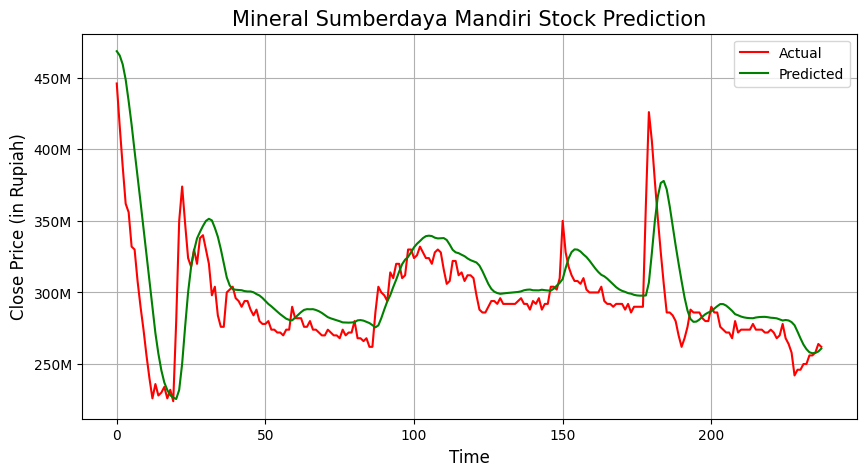

In [248]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/aksi_tanh_rmsprop.h5')

##### Tanh - AdaDelta

In [249]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 28s 642ms/step - loss: 0.0227 - val_loss: 0.1090
Epoch 2/10
24/24 [==============================] - 14s 574ms/step - loss: 0.0223 - val_loss: 0.1072
Epoch 3/10
24/24 [==============================] - 15s 627ms/step - loss: 0.0220 - val_loss: 0.1055
Epoch 4/10
24/24 [==============================] - 13s 558ms/step - loss: 0.0214 - val_loss: 0.1037
Epoch 5/10
24/24 [==============================] - 14s 569ms/step - loss: 0.0213 - val_loss: 0.1020
Epoch 6/10
24/24 [==============================] - 12s 518ms/step - loss: 0.0210 - val_loss: 0.1002
Epoch 7/10
24/24 [==============================] - 13s 538ms/step - loss: 0.0205 - val_loss: 0.0985
Epoch 8/10
24/24 [==============================] - 13s 538ms/step - loss: 0.0200 - val_loss: 0.0968
Epoch 9/10
24/24 [==============================] - 13s 552ms/step - loss: 0.0196 - val_loss: 0.0951
Epoch 10/10
24/24 [==============================] - 13s 541ms/step - loss: 0.0192 - val_lo

In [250]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 57ms/step
Mean Absolute Percentage Error (MAPE):  0.82848
Mean Absolute Error (MAE):  0.1248113
Mean Squared Error (MSE):  0.0159549
Root Mean Squared Error (RMSE):  0.12631
R-Squared:  -38.009779


8/8 [==============================] - 0s 56ms/step


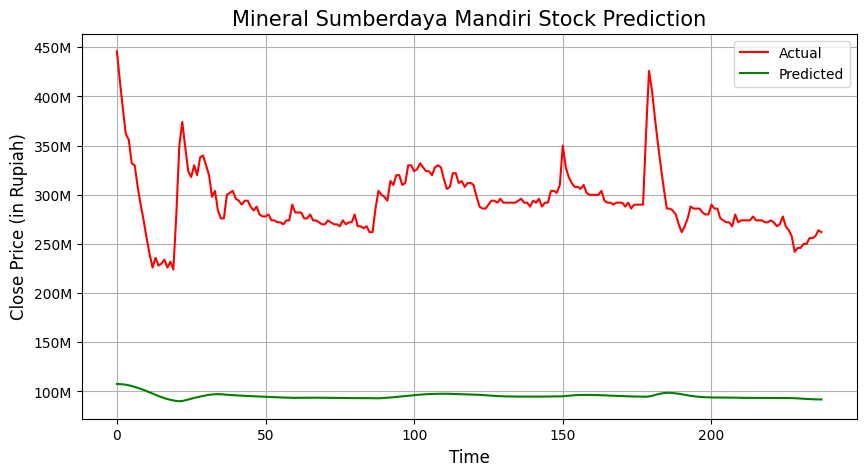

In [251]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/aksi_tanh_adadelta.h5')

##### Tanh - SGD

In [252]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 22s 583ms/step - loss: 0.0118 - val_loss: 0.0426
Epoch 2/10
24/24 [==============================] - 16s 652ms/step - loss: 0.0101 - val_loss: 0.0390
Epoch 3/10
24/24 [==============================] - 13s 537ms/step - loss: 0.0092 - val_loss: 0.0389
Epoch 4/10
24/24 [==============================] - 13s 529ms/step - loss: 0.0087 - val_loss: 0.0347
Epoch 5/10
24/24 [==============================] - 13s 528ms/step - loss: 0.0081 - val_loss: 0.0323
Epoch 6/10
24/24 [==============================] - 13s 522ms/step - loss: 0.0074 - val_loss: 0.0296
Epoch 7/10
24/24 [==============================] - 12s 509ms/step - loss: 0.0070 - val_loss: 0.0257
Epoch 8/10
24/24 [==============================] - 12s 494ms/step - loss: 0.0066 - val_loss: 0.0250
Epoch 9/10
24/24 [==============================] - 12s 514ms/step - loss: 0.0061 - val_loss: 0.0224
Epoch 10/10
24/24 [==============================] - 13s 557ms/step - loss: 0.0057 - val_lo

In [253]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 49ms/step
Mean Absolute Percentage Error (MAPE):  0.17051
Mean Absolute Error (MAE):  0.0265757
Mean Squared Error (MSE):  0.0009277
Root Mean Squared Error (RMSE):  0.03046
R-Squared:  -1.268319


8/8 [==============================] - 0s 53ms/step


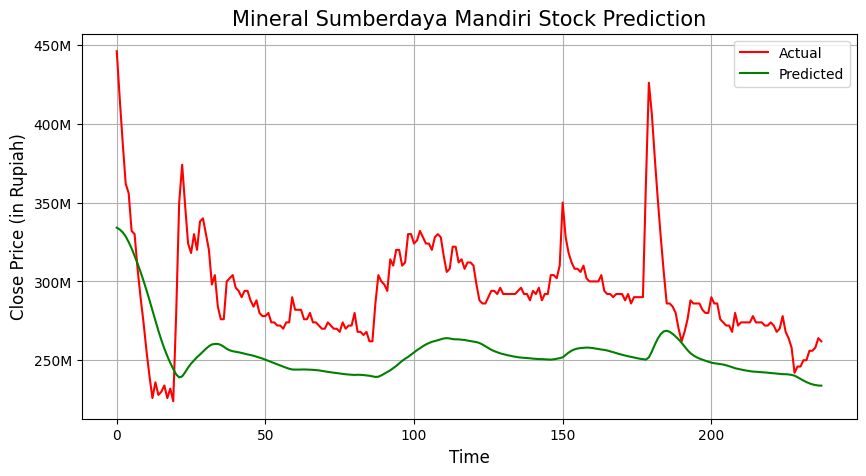

In [254]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/aksi_tanh_sgd.h5')

##### Tanh - Adamax

In [255]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 20s 528ms/step - loss: 0.0064 - val_loss: 0.0045
Epoch 2/10
24/24 [==============================] - 11s 458ms/step - loss: 0.0024 - val_loss: 0.0058
Epoch 3/10
24/24 [==============================] - 11s 448ms/step - loss: 0.0020 - val_loss: 0.0047
Epoch 4/10
24/24 [==============================] - 11s 442ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 5/10
24/24 [==============================] - 11s 453ms/step - loss: 0.0017 - val_loss: 0.0035
Epoch 6/10
24/24 [==============================] - 11s 469ms/step - loss: 0.0016 - val_loss: 0.0041
Epoch 7/10
24/24 [==============================] - 11s 454ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 8/10
24/24 [==============================] - 11s 444ms/step - loss: 0.0013 - val_loss: 0.0033
Epoch 9/10
24/24 [==============================] - 11s 452ms/step - loss: 0.0012 - val_loss: 0.0032
Epoch 10/10
24/24 [==============================] - 12s 486ms/step - loss: 0.0012 - val_lo

In [256]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 42ms/step
Mean Absolute Percentage Error (MAPE):  0.07762
Mean Absolute Error (MAE):  0.0121262
Mean Squared Error (MSE):  0.0003597
Root Mean Squared Error (RMSE):  0.01897
R-Squared:  0.120623


8/8 [==============================] - 0s 42ms/step


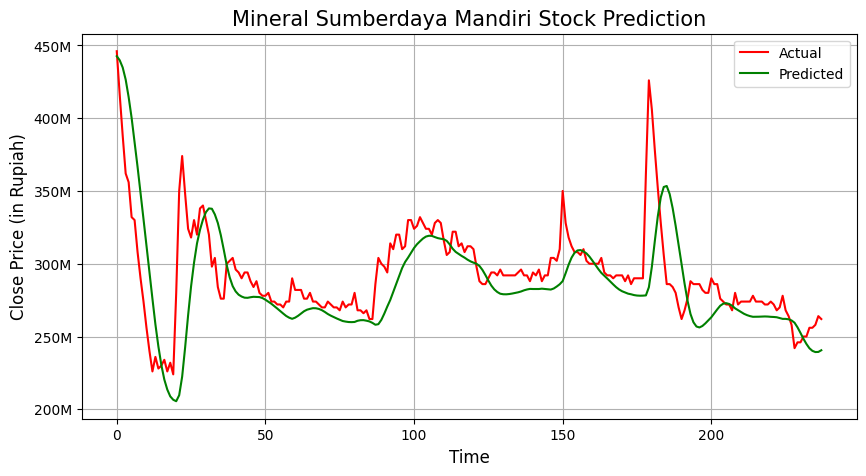

In [257]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/aksi_tanh_adamax.h5')

##### Comparison LSTM Model based on Activation and Optimizer Parameter

In [258]:
# Define the activation functions and optimizers to be tested
activations = ['linear', 'relu', 'tanh', 'sigmoid']
optimizers = ['adam', 'adagrad', 'nadam', 'rmsprop', 'adadelta', 'sgd', 'adamax']

# Generate all possible combinations of activation functions and optimizers
combinations = list(itertools.product(activations, optimizers))

# Define a function to build and train an LSTM model with a given activation function and optimizer
def build_model(activations, optimizers):
    model = Sequential()
    model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation=activations))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizers)
    model.fit(X_train, y_train, batch_size=100, epochs=10, validation_split=0.1, verbose=0)
    return model

# Train and evaluate the models for all possible combinations of activation functions and optimizers
results = []
for activations, optimizers in combinations:
    print(f'Training model with {activations} activation and {optimizers} optimizer')
    start_time = time.time()
    model = build_model(activations, optimizers)
    end_time = time.time()
    preds = model.predict(X_test)
    mape = round(metrics.mean_absolute_percentage_error(y_test, preds), 5)
    mae = round(metrics.mean_absolute_error(y_test, preds), 5)
    mse = round(metrics.mean_squared_error(y_test, preds), 5)
    rmse = round(math.sqrt(mse), 5)
    r2 = round(metrics.r2_score(y_test, preds), 2)
    elapsed_time = round(end_time - start_time, 2)
    results.append([activations, optimizers, mape, mae, mse, rmse, r2, elapsed_time])

# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 
                                           'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'], 
                                 index=['Activation', 'Optimizer'])

Training model with linear activation and adam optimizer
8/8 [==============================] - 2s 45ms/step
Training model with linear activation and adagrad optimizer
8/8 [==============================] - 2s 36ms/step
Training model with linear activation and nadam optimizer
8/8 [==============================] - 2s 35ms/step
Training model with linear activation and rmsprop optimizer
8/8 [==============================] - 2s 36ms/step
Training model with linear activation and adadelta optimizer
8/8 [==============================] - 2s 41ms/step
Training model with linear activation and sgd optimizer
8/8 [==============================] - 3s 51ms/step
Training model with linear activation and adamax optimizer
8/8 [==============================] - 2s 32ms/step
Training model with relu activation and adam optimizer
8/8 [==============================] - 3s 45ms/step
Training model with relu activation and adagrad optimizer
8/8 [==============================] - 2s 71ms/step
Training

In [259]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 
                                           'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'], 
                                 index=['Activation', 'Optimizer'])
# Get several LSTM model evaluation 
df_pivot_result.sort_values(by=['Activation', 'Optimizer'], ascending=True)

Elapsed Time (min)  MAE (%)  MAPE (%)  MSE (%)  \
Activation Optimizer                                                   
linear     adadelta                64.24  0.15718   1.04618  0.02516   
           adagrad                 79.26  0.04925   0.31698  0.00282   
           adam                   115.12  0.01404   0.09121  0.00032   
           adamax                  73.52  0.00999   0.06351  0.00028   
           nadam                  104.21  0.01248   0.08182  0.00028   
           rmsprop                 89.00  0.00881   0.05619  0.00025   
           sgd                     71.62  0.02363   0.15114  0.00079   
relu       adadelta                67.10  0.14179   0.94272  0.02051   
           adagrad                 71.45  0.05070   0.32754  0.00293   
           adam                    68.50  0.00812   0.05095  0.00020   
           adamax                  67.33  0.01529   0.10207  0.00044   
           nadam                   77.37  0.00850   0.05396  0.00022   
           rmsprop                 82.60  0.01072   0.06835  0.00032   
           sgd                     66.84  0.03825   0.24475  0.00178   
sigmoid    adadelta                61.43  0.38603   2.62787  0.14941   
           adagrad                 58.63  0.14947   0.99519  0.02272   
           adam                    59.90  0.04525   0.28967  0.00245   
           adamax                  63.34  0.02319   0.15604  0.00082   
           nadam                   66.34  0.02747   0.17942  0.00098   
           rmsprop                 61.04  0.02715   0.17715  0.00098   
           sgd                     61.64  0.04897   0.31503  0.00279   
tanh       adadelta                60.22  0.13490   0.89627  0.01860   
           adagrad                 66.82  0.04137   0.26457  0.00207   
           adam                    65.36  0.00788   0.04942  0.00018   
           adamax                  57.59  0.01543   0.09973  0.00040   
           nadam                   74.12  0.00833   0.05287  0.00020   
           rmsprop                 60.63  0.01108   0.07095  0.00028   
           sgd                     59.54  0.02258   0.14458  0.00073   

                      R-Squared (%)  RMSE (%)  
Activation Optimizer                           
linear     adadelta          -60.51   0.15862  
           adagrad            -5.89   0.05310  
           adam                0.22   0.01789  
           adamax              0.32   0.01673  
           nadam               0.31   0.01673  
           rmsprop             0.38   0.01581  
           sgd                -0.94   0.02811  
relu       adadelta          -49.16   0.14321  
           adagrad            -6.16   0.05413  
           adam                0.50   0.01414  
           adamax             -0.09   0.02098  
           nadam               0.46   0.01483  
           rmsprop             0.22   0.01789  
           sgd                -3.34   0.04219  
sigmoid    adadelta         -364.31   0.38654  
           adagrad           -54.55   0.15073  
           adam               -4.99   0.04950  
           adamax             -1.00   0.02864  
           nadam              -1.39   0.03130  
           rmsprop            -1.41   0.03130  
           sgd                -5.83   0.05282  
tanh       adadelta          -44.47   0.13638  
           adagrad            -4.05   0.04550  
           adam                0.55   0.01342  
           adamax              0.02   0.02000  
           nadam               0.51   0.01414  
           rmsprop             0.30   0.01673  
           sgd                -0.79   0.02702

In [260]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 
                                           'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'], 
                                 index=['Activation', 'Optimizer'])

# Calculate t-statistics and p-values for each performance metric
for col in ['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)']:
    t_stat, p_val = stats.ttest_1samp(df_result[col], 0.05)
    new_col_name_tstat = '{} (t-Statistic)'.format(col)
    new_col_name_pval = '{} (p-Value)'.format(col)
    df_pivot_result[new_col_name_tstat] = round(t_stat, 5)
    df_pivot_result[new_col_name_pval] = round(p_val, 5)

# Print the resulting pivot table with the horizontal t-statistic and p-value columns
df_pivot_result.sort_values(by=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'Elapsed Time (min)'], ascending=True)

Elapsed Time (min)  MAE (%)  MAPE (%)  MSE (%)  \
Activation Optimizer                                                   
tanh       adam                    65.36  0.00788   0.04942  0.00018   
relu       adam                    68.50  0.00812   0.05095  0.00020   
tanh       nadam                   74.12  0.00833   0.05287  0.00020   
relu       nadam                   77.37  0.00850   0.05396  0.00022   
linear     rmsprop                 89.00  0.00881   0.05619  0.00025   
           adamax                  73.52  0.00999   0.06351  0.00028   
relu       rmsprop                 82.60  0.01072   0.06835  0.00032   
tanh       rmsprop                 60.63  0.01108   0.07095  0.00028   
linear     nadam                  104.21  0.01248   0.08182  0.00028   
           adam                   115.12  0.01404   0.09121  0.00032   
tanh       adamax                  57.59  0.01543   0.09973  0.00040   
relu       adamax                  67.33  0.01529   0.10207  0.00044   
tanh       sgd                     59.54  0.02258   0.14458  0.00073   
linear     sgd                     71.62  0.02363   0.15114  0.00079   
sigmoid    adamax                  63.34  0.02319   0.15604  0.00082   
           rmsprop                 61.04  0.02715   0.17715  0.00098   
           nadam                   66.34  0.02747   0.17942  0.00098   
relu       sgd                     66.84  0.03825   0.24475  0.00178   
tanh       adagrad                 66.82  0.04137   0.26457  0.00207   
sigmoid    adam                    59.90  0.04525   0.28967  0.00245   
           sgd                     61.64  0.04897   0.31503  0.00279   
linear     adagrad                 79.26  0.04925   0.31698  0.00282   
relu       adagrad                 71.45  0.05070   0.32754  0.00293   
tanh       adadelta                60.22  0.13490   0.89627  0.01860   
relu       adadelta                67.10  0.14179   0.94272  0.02051   
sigmoid    adagrad                 58.63  0.14947   0.99519  0.02272   
linear     adadelta                64.24  0.15718   1.04618  0.02516   
sigmoid    adadelta                61.43  0.38603   2.62787  0.14941   

                      R-Squared (%)  RMSE (%)  MAPE (%) (t-Statistic)  \
Activation Optimizer                                                    
tanh       adam                0.55   0.01342                 2.97788   
relu       adam                0.50   0.01414                 2.97788   
tanh       nadam               0.51   0.01414                 2.97788   
relu       nadam               0.46   0.01483                 2.97788   
linear     rmsprop             0.38   0.01581                 2.97788   
           adamax              0.32   0.01673                 2.97788   
relu       rmsprop             0.22   0.01789                 2.97788   
tanh       rmsprop             0.30   0.01673                 2.97788   
linear     nadam               0.31   0.01673                 2.97788   
           adam                0.22   0.01789                 2.97788   
tanh       adamax              0.02   0.02000                 2.97788   
relu       adamax             -0.09   0.02098                 2.97788   
tanh       sgd                -0.79   0.02702                 2.97788   
linear     sgd                -0.94   0.02811                 2.97788   
sigmoid    adamax             -1.00   0.02864                 2.97788   
           rmsprop            -1.41   0.03130                 2.97788   
           nadam              -1.39   0.03130                 2.97788   
relu       sgd                -3.34   0.04219                 2.97788   
tanh       adagrad            -4.05   0.04550                 2.97788   
sigmoid    adam               -4.99   0.04950                 2.97788   
           sgd                -5.83   0.05282                 2.97788   
linear     adagrad            -5.89   0.05310                 2.97788   
relu       adagrad            -6.16   0.05413                 2.97788   
tanh       adadelta          -44.47 

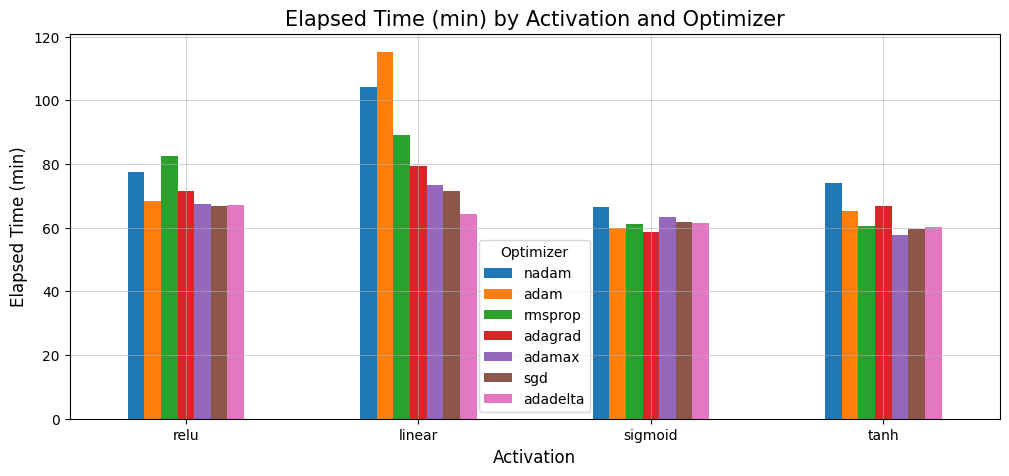

In [261]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_time = df_result.pivot_table(index='Activation', columns='Optimizer', values='Elapsed Time (min)')
# Sort the columns based on the mean elapsed time value
df_time = df_time[df_time.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_time = df_time.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean elapsed time value
df_time = df_time.sort_values(by=df_time.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_time.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Elapsed Time (min)', fontsize=12)
ax.set_title('Elapsed Time (min) by Activation and Optimizer', fontsize=15)
# formatter = ticker.PercentFormatter(xmax=1, decimals=0)
# ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

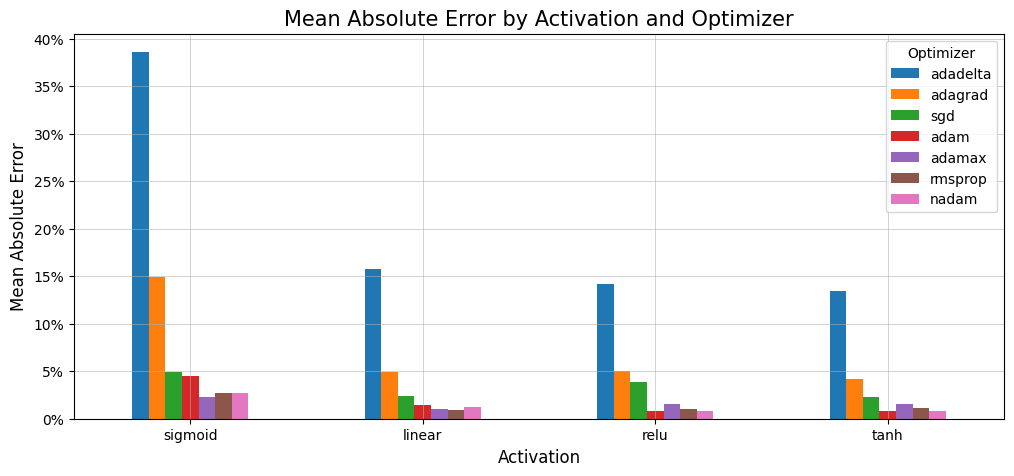

In [262]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mae = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAE (%)')
# Sort the columns based on the mean MAE value
df_mae = df_mae[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mae = df_mae.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean MAE value
df_mae = df_mae.sort_values(by=df_mae.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mae.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Error', fontsize=12)
ax.set_title('Mean Absolute Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

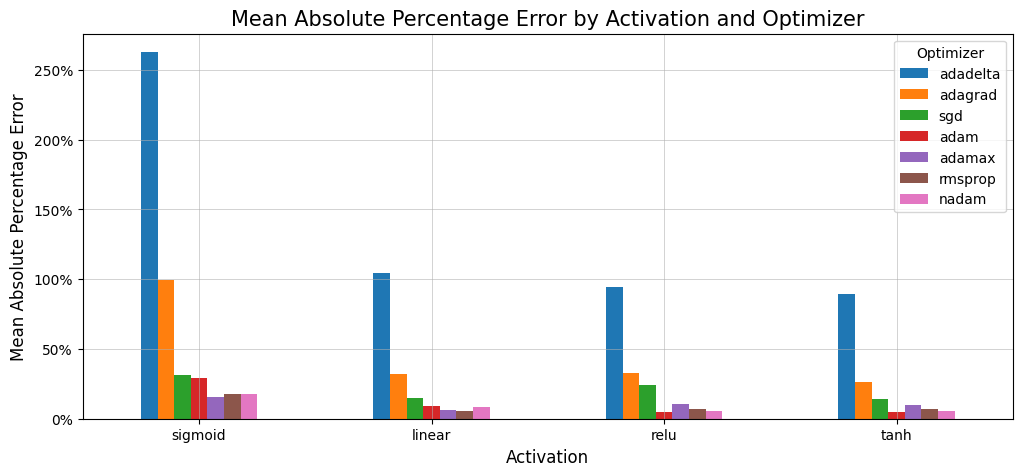

In [263]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mape = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAPE (%)')
# Sort the columns based on the mean MAPE value
df_mape = df_mape[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mape = df_mape.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean MAPE value
df_mape = df_mape.sort_values(by=df_mape.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mape.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Percentage Error', fontsize=12)
ax.set_title('Mean Absolute Percentage Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

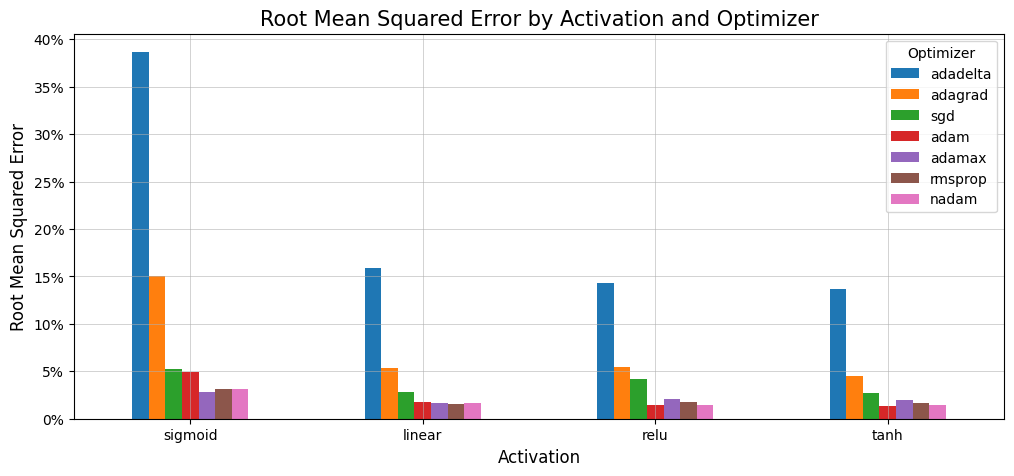

In [267]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_rmse = df_result.pivot_table(index='Activation', columns='Optimizer', values='RMSE (%)')
# Sort the columns based on the mean RMSE value
df_rmse = df_rmse[df_rmse.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_rmse = df_rmse.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean RMSE value
df_rmse = df_rmse.sort_values(by=df_rmse.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_rmse.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Root Mean Squared Error', fontsize=12)
ax.set_title('Root Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

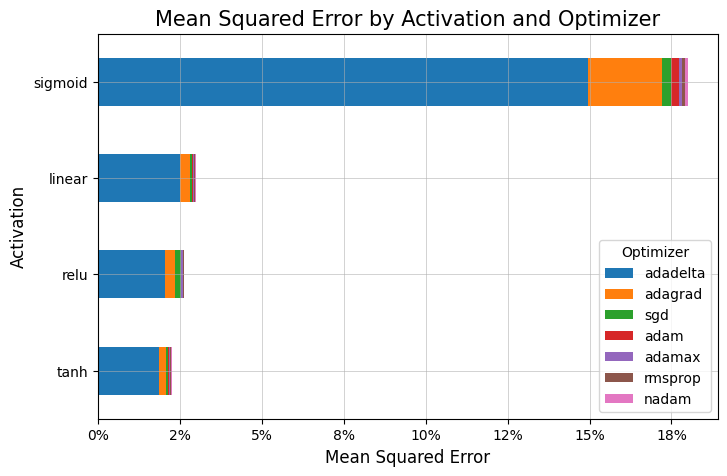

In [276]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mse = df_result.pivot_table(index='Activation', columns='Optimizer', values='MSE (%)')
# Sort the columns based on the mean MSE value
df_mse = df_mse[df_mse.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mse = df_mse.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean MSE value
df_mse = df_mse.sort_values(by=df_mse.columns[-1], ascending=True)

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(8,5))
df_mse.plot(kind='barh', stacked=True, ax=ax) # modified line
ax.set_xlabel('Mean Squared Error', fontsize=12)
ax.set_ylabel('Activation', fontsize=12) # modified line
ax.set_title('Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.xaxis.set_major_formatter(formatter) # modified line
ax.grid(True, linewidth='0.4')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0) # modified line
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

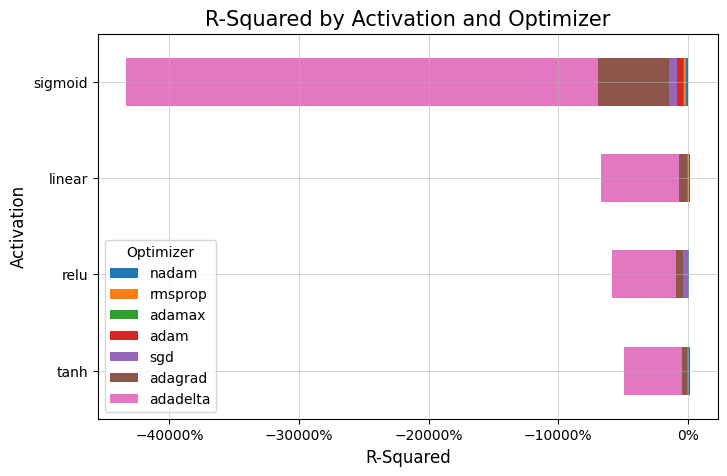

In [282]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_r2 = df_result.pivot_table(index='Activation', columns='Optimizer', values='R-Squared (%)')
# Sort the columns based on the mean R2 value
df_r2 = df_r2[df_r2.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_r2 = df_r2.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean R2 value
df_r2 = df_r2.sort_values(by=df_rmse.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(8,5))
df_r2.plot(kind='barh', stacked=True, ax=ax)
ax.set_xlabel('R-Squared', fontsize=12)
ax.set_ylabel('Activation', fontsize=12)
ax.set_title('R-Squared by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.xaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()